In [1]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

import sys
print("User Current Version:-", sys.version)

not_base
User Current Version:- 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]


In [2]:
'''


This notebook preprosses single cell data from cell ranger output to clutering .

THe same pbmc3k data used in the seurat tutorial is used as an example  

It largely follows the scanpy tutorial 
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html


'''

'\n\n\nThis notebook preprosses single cell data from cell ranger output to clutering .\n\nTHe same pbmc3k data used in the seurat tutorial is used as an example  \n\nIt largely follows the scanpy tutorial \nhttps://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html\n\n\n'

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

# Download data and load modules / paths 

In [3]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write


In [4]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
repo_parent_dir='../../'

import sys
if repo_parent_dir not in sys.path:
    sys.path.append(repo_parent_dir)

# import the package
import actio_single_cell_python_tools as sctl
# import the preprocessing class module
from actio_single_cell_python_tools.sctl_gex_class import *


In [6]:
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

## common parameters for dataset

In [7]:
pbmc3k_parameters={

"output_prefix":'EX_pbmc3k_raw_sctl_',
"output_dir":'./pbmc3k_raw_sctl/',

    
"n_jobs": 16,
#### dataset specfic parameters
###Basic filters
"filter_genes_min_cells":3,  # min of cells a gene is detected in else gene is tossed out default 3
"filter_genes_min_counts":0, # min  of counts a gene must have to pass basic filter default 0
"filter_cells_min_genes":200, # min  of genes detected or else cell/observation is tossed out default 200
"filter_cells_min_counts":0, # min  of counts detected or else cell/observation is tossed out default 0  
    
####Filter  on off switches
"filter_ncount" : True,
"filter_pct_mt" : True,
"filter_pct_ribo" : False,
"filter_pct_hb" : False,
"filter_pct_malat1":False,
"filter_HVG" : True,

###less than filter percent 
"n_genes_bycounts" : 2500, #less than filter
"percent_mt" : 5, #less than filter
"percent_ribo" : 100, #less than filter
"percent_malat1": 100, #less than filter
"percent_hb" : 100,  #less than filter

###Greater than filter percent
"over_n_genes_bycounts" : 200, #greater than filter
"over_percent_mt" : 0, #greater than filter
"over_percent_ribo" : 0, #greater than filter
"over_percent_malat1": 0, #greater than filter
"over_percent_hb" : 0 , #greater than filter

###Remove gene sets  on off switches
"remove_MALAT1" : False, 
"remove_MT" : False ,
"remove_HB" : False,
"remove_RP_SL" : False ,
"remove_MRP_SL" : False,

#### processing parameters and options
"filter_genes_min_counts_normed":0,
"normalize_total_target_sum" : 1e4,  # scanpy  default 1e4
"HVG_min_mean"  :  0.0125, # scanpy  default 0.0125
"HVG_max_mean"  :  3, # scanpy  default 3
"HVG_min_disp"  :  0.5, # scanpy  default 0.5
"logarithmize":True, # scanpy default True
"scale":True, # scanpy default True
    
####regression on off switches
"regress_mt" : True,
"regress_ribo" : False,
"regress_malat1":False,
"regress_hb" : False,
"regress_cell_cycle_score" : False,

###clustering parameters for clusters
"number_of_PC" : 40, ### dataset demensionality 
"number_of_neighbors" : 10,
"leiden_res" : .9, #leiden clustering resolution


# UMAP graph parameters
'umap_marker_gene':True,
'umap_marker_gene_list': ['IL7R','CD14','LYZ', 'MS4A1','CD8A','GNLY','NKG7','FCGR3A','MS4A7','FCER1A','CST3','PPBP'],

#cluster naming parameters
'rename_cluster': True,
####  'NK' and 'FCGR3A Monocytes' seem to switch places sometimes .. not sure if its random or a bug, NK cluster should be close to CD8 T cells
    'new_cluster_names' : [  'CD4 T', 'CD14 Monocytes', 'B','CD8 T',   'FCGR3A Monocytes','NK','Dendritic', 'Megakaryocytes']
#'new_cluster_names' : [  'CD4 T', 'CD14 Monocytes', 'B','CD8 T',   'NK','FCGR3A Monocytes','Dendritic', 'Megakaryocytes']  

}

parameters=pbmc3k_parameters.copy()

# use adata and scanpy tools package functions scanpy wrappers

### first lets try some doc strings 

In [8]:
print(sctl.pp.basic_filitering.__doc__)

 Basic Filtering
    #### code 
    def basic_filitering(adata,
                     filter_cells_min_counts=0,
                      filter_cells_min_genes=200,
                     filter_genes_min_cells=3,
                     filter_genes_min_counts=0,
                     **parameters
                     ):
    print(f'number of Cells BEFORE Basic Filtering : {adata.n_obs}')
    sc.pp.filter_cells(adata, min_genes=filter_cells_min_genes,)  #min_genes=over_n_genes_bycounts
    print(f'Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_genes)  Cells remaining : {adata.n_obs}')
    sc.pp.filter_cells(adata,min_counts=filter_cells_min_counts,)  # cells / observations must have min # of coutns
    print(f'Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_counts)  Cells remaining : {adata.n_obs}')
    sc.pp.filter_genes(adata, min_cells=filter_genes_min_cells ) #genes must be present in min # of cells / observations
    print(f'Filtering genes pp.filter_g

In [9]:
print(sctl.pp.annotate_n_view_adata_raw_counts.__doc__)

  
    Annotate technical gene groups  and calculate qc metrics
    #### code 
    annotate_QC_genes(adata)
    calculate_qc_metrics(adata)
    plot_qc_metrics(adata)
    


In [10]:
print(sctl.pp.annotate_QC_genes.__doc__)
print(sctl.pp.calculate_qc_metrics.__doc__)
print(sctl.pp.plot_qc_metrics.__doc__)

 
    if organism == 'human' or None:
        print ('organism is human, annotating human genes')
        adata.var['mt'] = adata.var_names.str.startswith("MT-")  # mitochondrial genes as 'mt'
        adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # ribosomal genes genes as 'ribo'
        adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)(S)]")) & ~adata.var_names.str.contains(("HBEGF")) 
        # "^HB[^(P)" changed to "^HB[^(P)(S)" and  & ~adata_test.var_names.str.contains(("HBEGF")) added to remove HBS1L and HBEGF which are NOT memoglobin genes
        adata.var['malat1'] = adata.var_names.str.contains(("MALAT1"))  # MALAT1 genes as 'malat1'
    if organism == 'mouse':
        print ('organism is mouse, annotating mouse genes')
        adata.var['mt'] = adata.var_names.str.startswith("mt-")  # mitochondrial genes as 'mt'
        adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl")) # ribosomal genes genes as 'ribo'
        adata.var['hb'] = adat

In [11]:
print(sctl.pp.annotate_n_view_adata_raw_counts.__doc__)

  
    Annotate technical gene groups  and calculate qc metrics
    #### code 
    annotate_QC_genes(adata)
    calculate_qc_metrics(adata)
    plot_qc_metrics(adata)
    


In [12]:
print(sctl.pp.remove_genes.__doc__)

 ################################# Remove Filter out genes with ""techincal bias""
    
    
    #### code
    
    def remove_genes(adata,
                remove_MALAT1=False,
                remove_MT=False,
                remove_HB=False,
                remove_RP_SL=False,
                remove_MRP_SL=False,
                 **parameters
                ):
    
    ### Remove gene sets  on off switches
    print(f'####################################################  remove_genes')
    print(f'remove_MALAT1 {remove_MALAT1}')
    print(f'remove_MT {remove_MT}')
    print(f'remove_HB {remove_HB}')
    print(f'remove_RP_SL {remove_RP_SL}')
    print(f'remove_MRP_SL {remove_MRP_SL} ')
    print(f' BEFORE filtering for specific gene : number of Cells {adata.n_obs}, number of genes {adata.n_vars}')
    nothing = adata.var_names.str.startswith('NO_GENES_HAVE_THIS_NAME')
    remove = np.add(nothing, nothing)
    print(len((nothing)))
    if remove_MALAT1==True:
        malat1 = adata.var

In [13]:
print(sctl.pp.process2scaledPCA.__doc__)


    
    #### code
    
def process2scaledPCA(adata,
                   normalize_total_target_sum=1e4,logarithmize=True,
                   filter_HVG=False,HVG_min_mean=0.0125, HVG_max_mean=3, HVG_min_disp=3,
                   regress_mt=False,regress_ribo=False,regress_malat1=False,regress_hb=False,
                   scale=True,PCA=True,
                   regress_cell_cycle_score=False,HVG_flavor='seurat',HVG_n_top_genes=1500,
                      **parameters):
        
    ################################## library-size correct  the data:    
    ################################## Logarithmize    
    norm_log(adata,normalize_total_target_sum,logarithmize, **parameters)
    #################################  HVG selection
    if HVG_flavor=='seurat':
        print(f'############### HVG_flavor=seurat')
        if logarithmize==True:
            adata=HVG_selection_log_norm_seurat(adata,filter_HVG,HVG_min_mean, HVG_max_mean, HVG_min_disp, **parameters)
        else:
           

In [14]:
print(sctl.pp.leiden_clustering.__doc__)


    #### code
    leiden_clustering(adata, number_of_neighbors=10,number_of_PC=40, leiden_res=1,key_added='leiden', **parameters)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=leiden_res,key_added=key_added)
    sc.pl.umap(adata, color=[key_added] )
    


In [15]:
print(sctl.pl.silhouette_score_n_plot.__doc__)


    adsctl.pl.silhouette_score_n_plot(adata,parameters,leiden_res='unk'):
    > assumes ledien clusteirng to subset cells
    > uses X_pca for silhoutte_scores
    samples_silhoutte_scores=silhouette_samples(adata.obsm['X_pca'], adata.obs['leiden']
  
    


In [16]:
print(sctl.pp.rename_leiden_clusters.__doc__)


    rename_leiden_clusters_old(adata,parameters=None,rename_cluster=False,new_cluster_names=None,new_obs_key='Cell_Clusters_Named'):
    


## ok now load data and parameters 

In [17]:
data_directory='./data/filtered_gene_bc_matrices/hg19/'

adata_raw_counts = sc.read_10x_mtx(
    data_directory,  # the directory with the `.mtx` file
    var_names='gene_symbols',              
    make_unique=True,
    cache=False)     # use True when not on github  
adata_raw_counts.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata_raw_counts

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [18]:
# add the parameters the adata.uns dictionary
adata_raw_counts.uns["parameters"]=parameters

In [19]:
adata=adata_raw_counts.copy()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    uns: 'parameters'

## do the processing

24.2 MB
None
number of Cells BEFORE Basic Filtering : 2700
Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_genes)  Cells remaining : 2700
min_cells=filter_cells_min_genes =  200
Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_counts)  Cells remaining : 2700
min_counts=filter_cells_min_counts =  0
number of GENES BEFORE Basic Filtering : 32738
Filtering genes pp.filter_genes(adata, min_cells=filter_genes_min_cells)  Genes remaining : 13714
min_cells=filter_genes_min_cells =  3
Filtering genes pp.filter_genes(adata, min_counts=filter_genes_min_counts)  Genes remaining :  13714
min_counts=filter_genes_min_counts =  0
number of Cells AFTER basic_filitering : 2700
number of Genes AFTER basic_filitering : 13714
21.2 MB
None
AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts'
    uns: 'parameters'
organism is human, annotating human genes


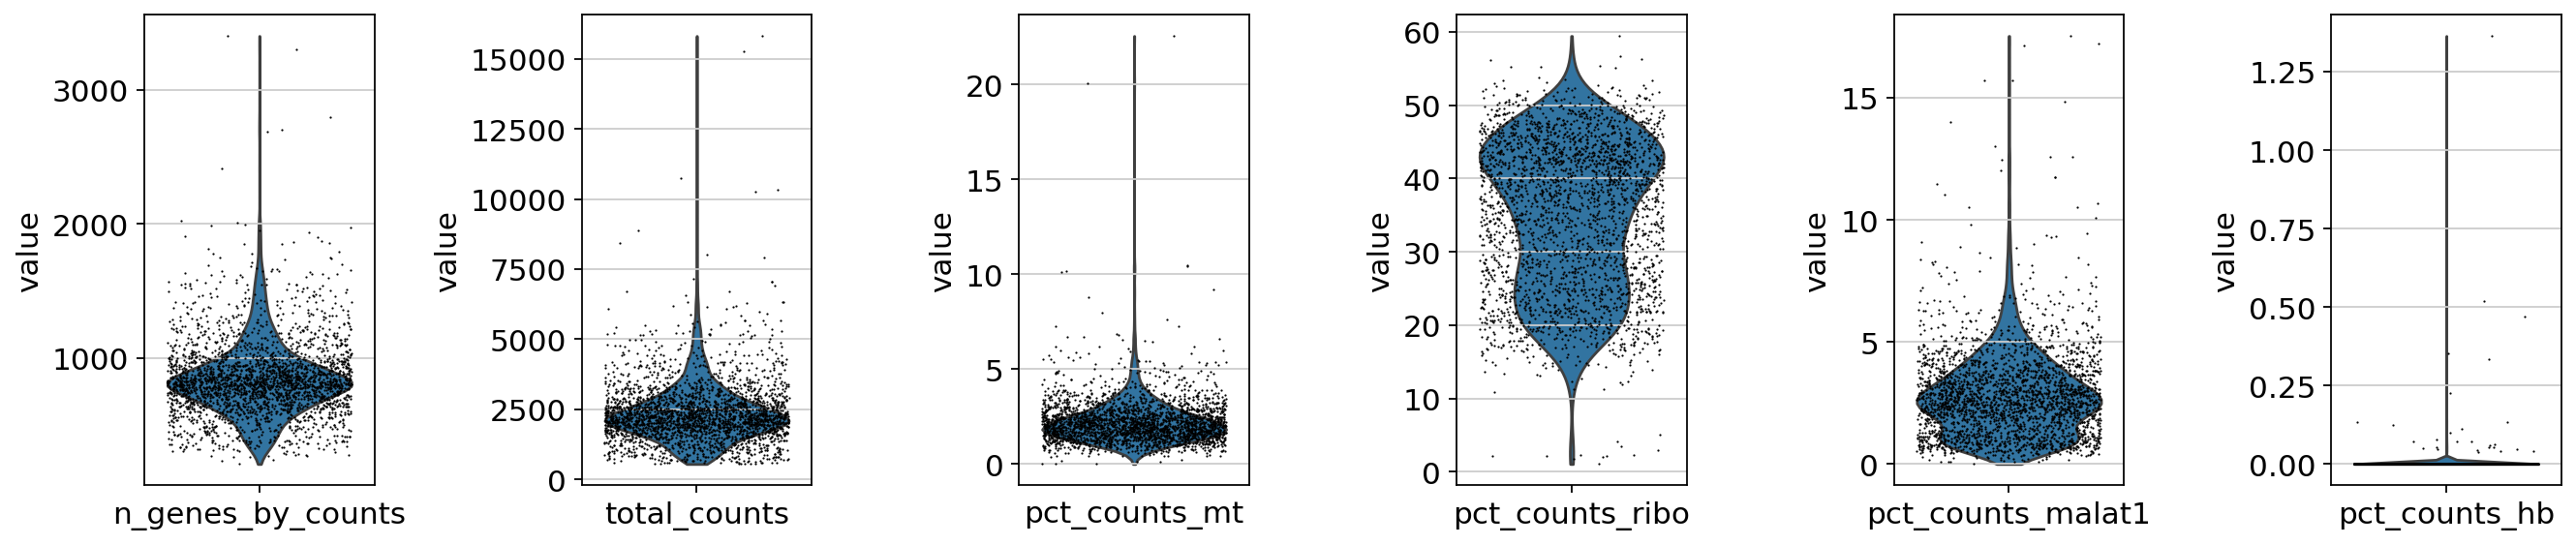

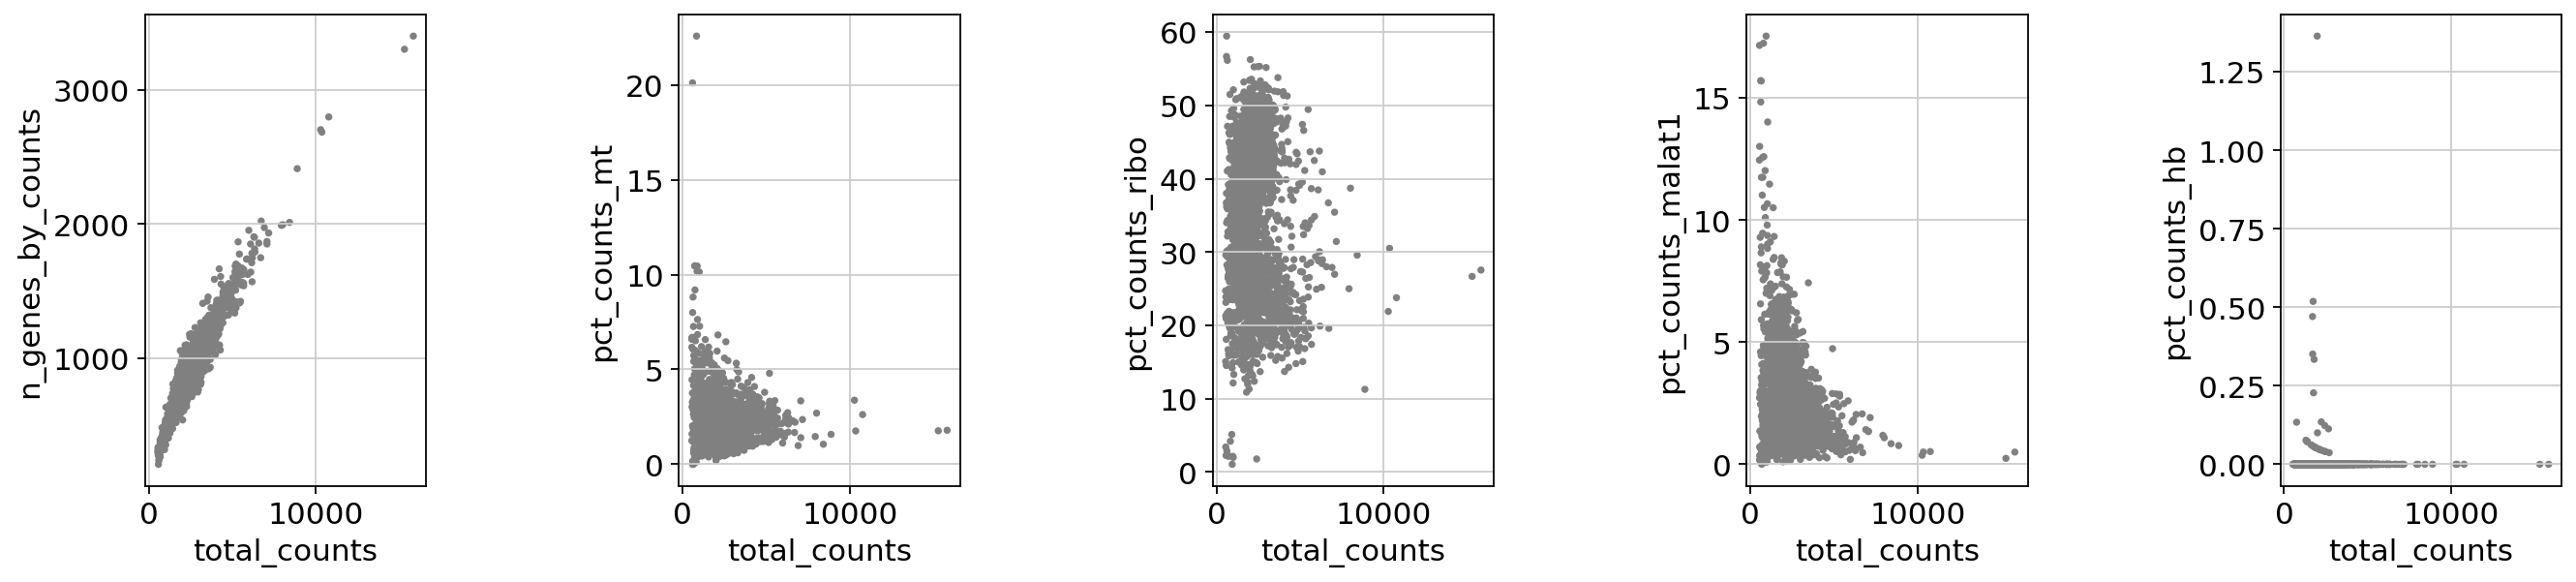

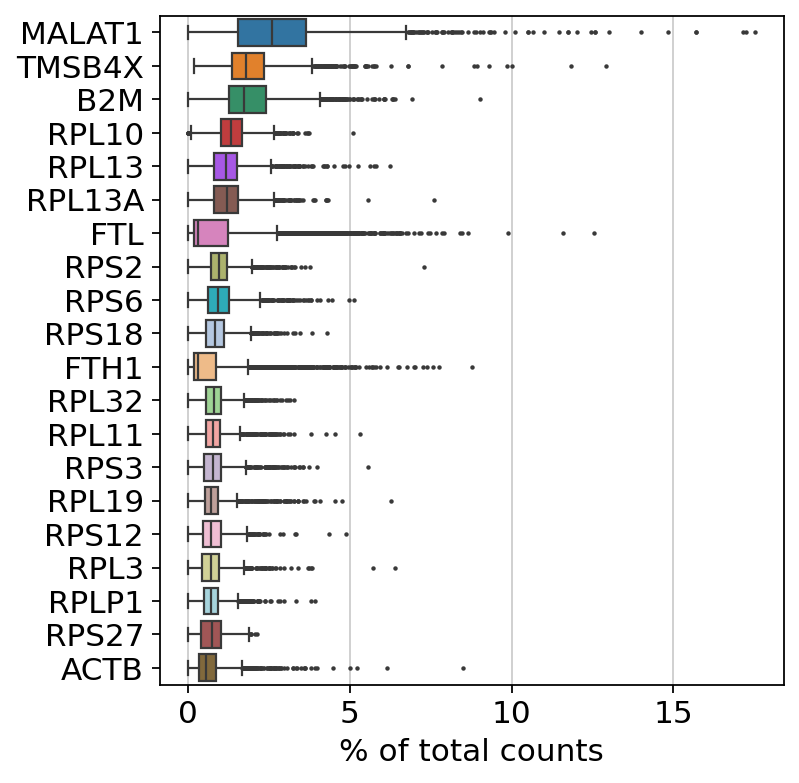

21.6 MB
None
 True keep cells with less than 2500 (n_genes_bycounts) dected genes 
 True keep cells with less than 5 (percent_mt) mitochondiral gene counts 
 True keep cells with greater than 0 (percent_mt) mitochondiral gene counts 
 False keep cells with less than 100 (percent_ribo) ribosomal protein gene counts 
 False keep cells with greater than 0 (percent_ribo) ribosomal protein gene counts 
 False keep cells with less than 100 (percent_hb) hemoglobin protein gene counts 
 False keep cells with greater than 0 (percent_ribo) ribosomal protein gene counts 
 False keep cells with less than 100 (percent_hb) hemoglobin protein gene counts 
 False keep cells with greater than 0 (percent_ribo) ribosomal protein gene counts 
number of Cells BEFORE pct Filtering : 2700
number of Cells AFTER n_genes_bycounts Filtering : 2695
number of Cells AFTER percent_mt Filtering : 2638
number of Cells AFTER over_percent_mt Filtering : 2638
number of Cells AFTER filter_cells_by_anotated_QC_gene : 2638


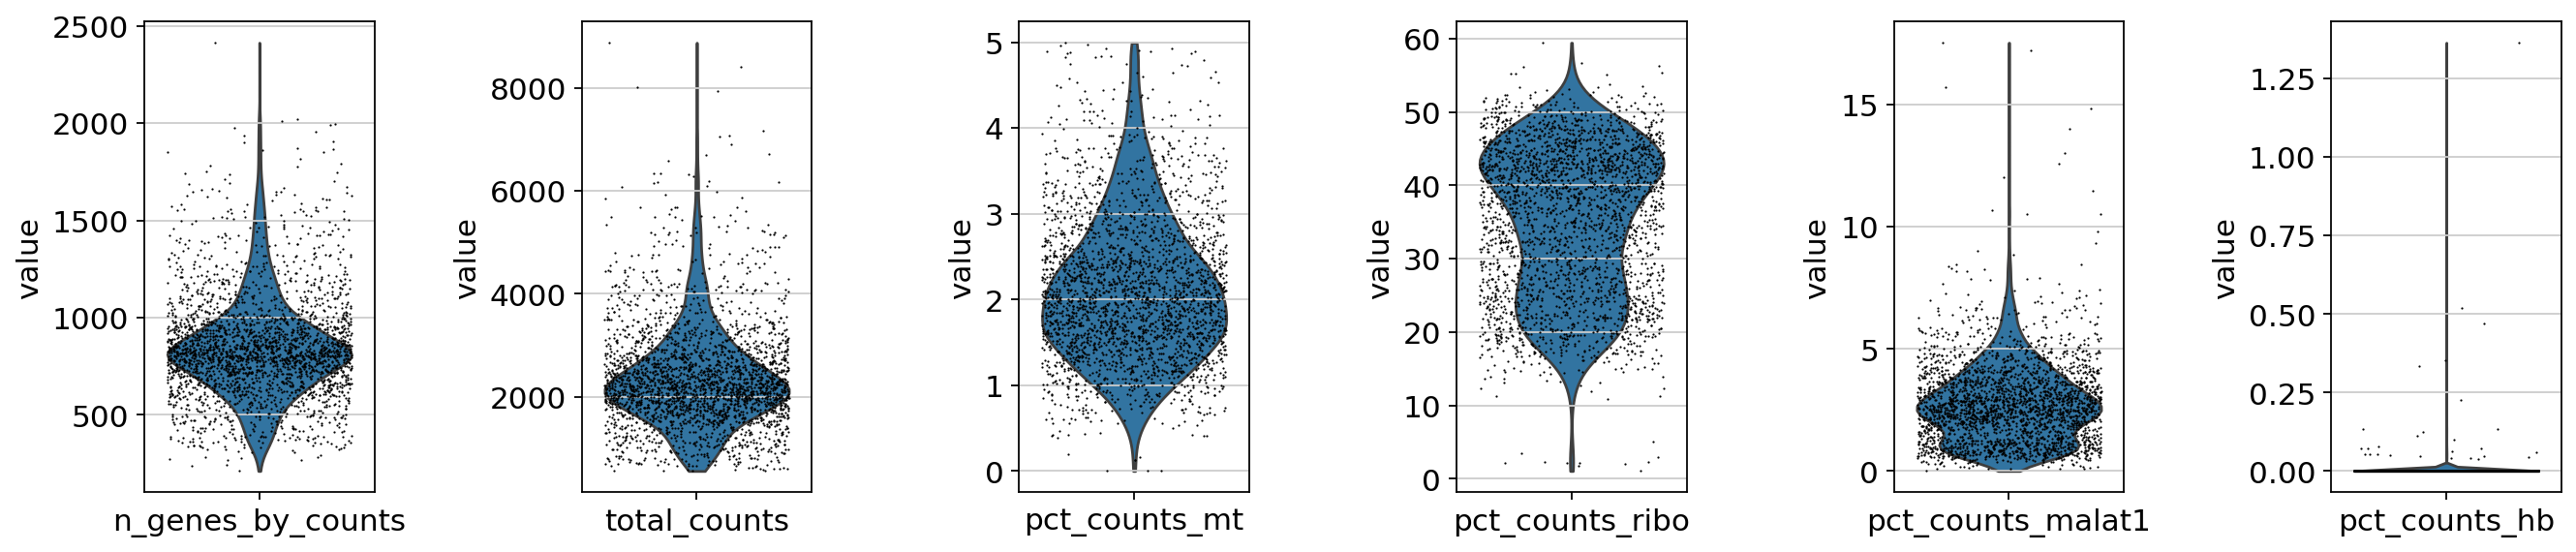

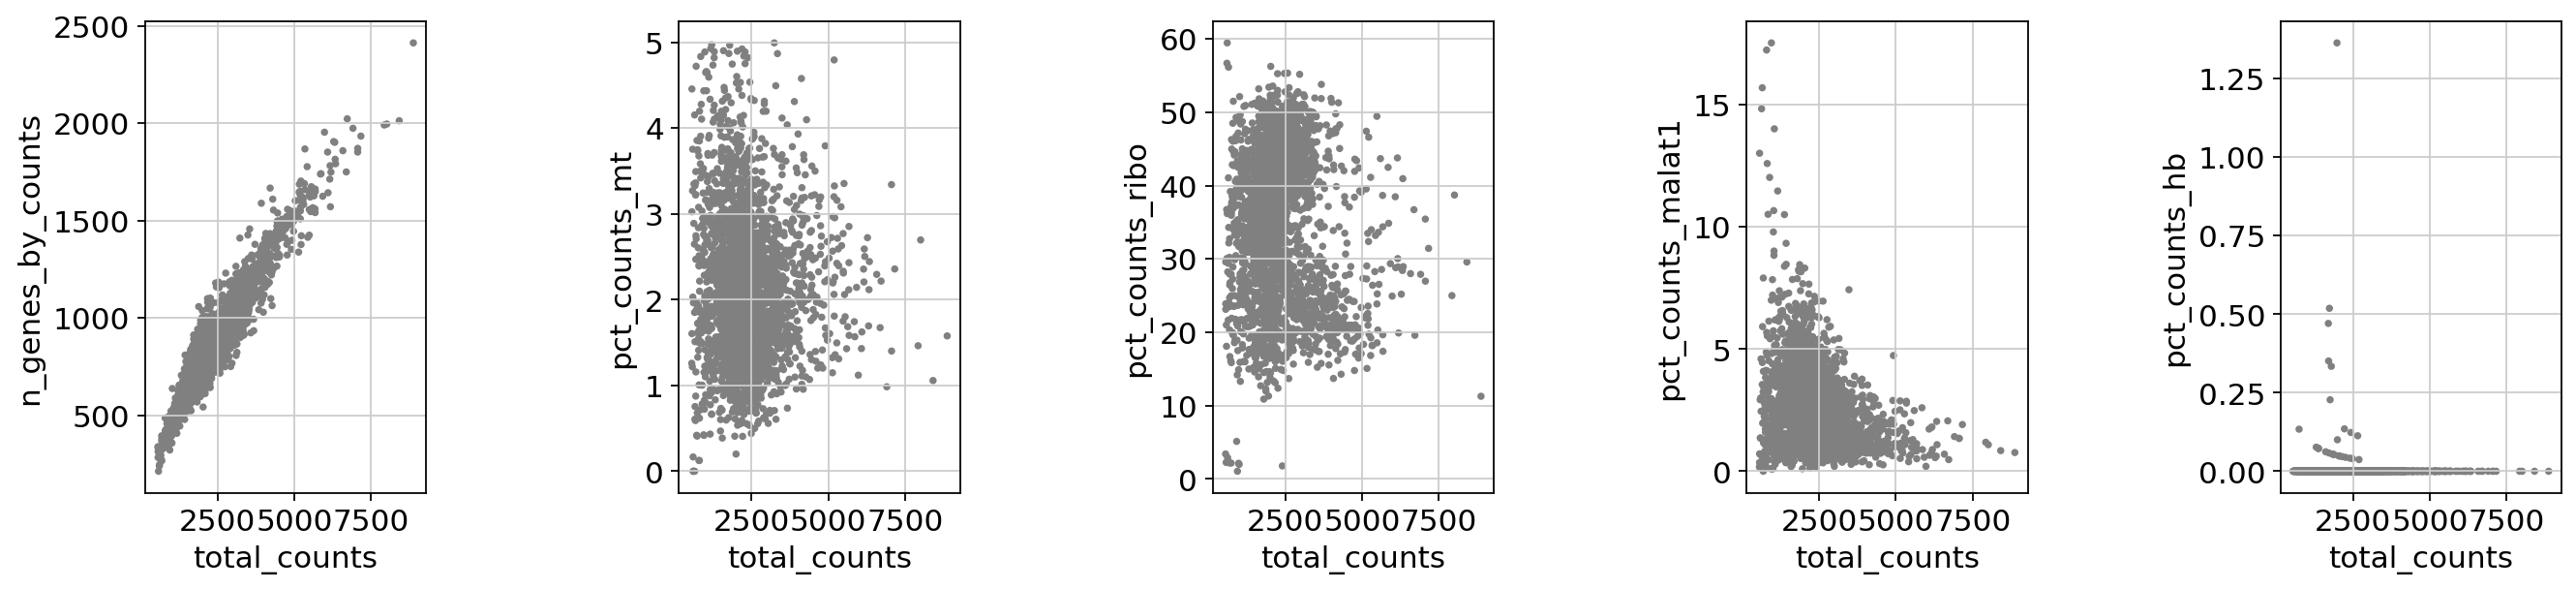

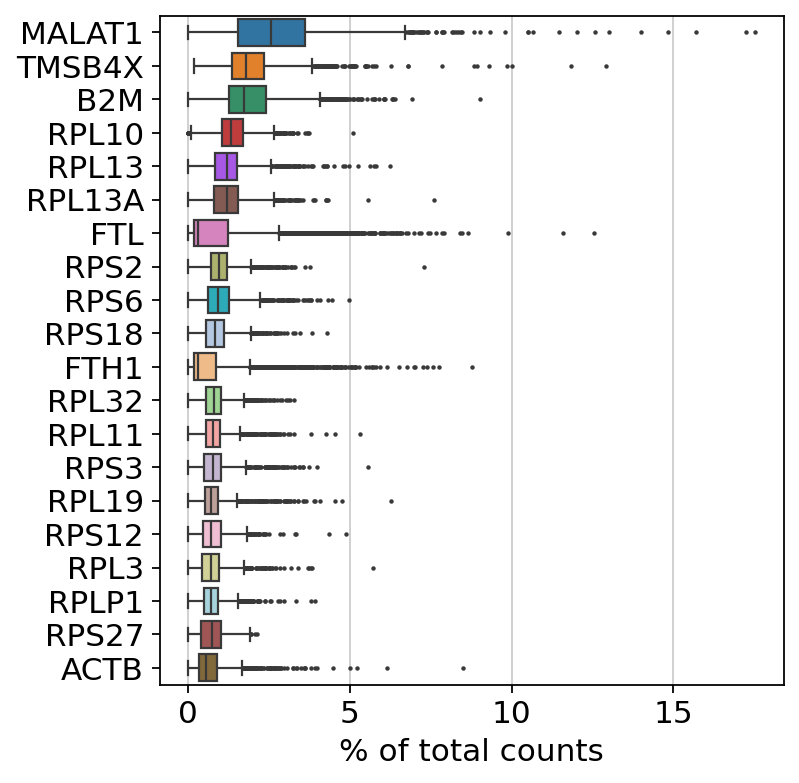

21.2 MB
None
AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'parameters'
21.2 MB
None
####################################################  remove_genes
remove_MALAT1 False
remove_MT False
remove_HB False
remove_RP_SL False
remove_MRP_SL False 
 BEFORE filtering for specific gene : number of Cells 2638, number of genes 13714
13714
 AFTER filtering for specific gene : number of Cells 2638, number of genes 13714
number of Cells AFTER remove_genes : 2638
number of Genes AFTER remove_genes: 13714
####################################################  plot_qc_metrics after filters and gene removal 
21.2 MB
None
C

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'parameters'

In [20]:
%%time
'''

'''
print(sctl.tl.print_size_in_MB(adata))
sc.settings.n_jobs = adata.uns["parameters"]["n_jobs"]

################# do basic filtering of cells and genes
sctl.pp.basic_filitering(adata,**adata.uns["parameters"])
print(f'number of Cells AFTER basic_filitering : {adata.n_obs}')
print(f'number of Genes AFTER basic_filitering : {adata.n_vars}')
print(sctl.tl.print_size_in_MB(adata))
print(adata)
################# annotate and view basic QC stats before addtioanl filteing

#adata=sctl.pp.annotate_n_view_adata_raw_counts(adata)
sctl.pp.annotate_n_view_adata_raw_counts(adata)
print(sctl.tl.print_size_in_MB(adata))


################# filter by QC metrics 
adata=sctl.pp.filter_cells_by_anotated_QC_gene(adata,**adata.uns["parameters"])
print(f'number of Cells AFTER filter_cells_by_anotated_QC_gene : {adata.n_obs}')
print(f'number of Genes AFTER filter_cells_by_anotated_QC_gene: {adata.n_vars}')
print(sctl.tl.print_size_in_MB(adata))
print(adata)
#################  re annoate / re calc  and  after fitlering  by QC metrics   

sctl.pp.annotate_n_view_adata_raw_counts(adata)
print(sctl.tl.print_size_in_MB(adata))
print(adata)


print(sctl.tl.print_size_in_MB(adata))
################# remove specfic "techical" gene groups 
adata=sctl.pp.remove_genes(adata,**adata.uns["parameters"])
print(f'number of Cells AFTER remove_genes : {adata.n_obs}')
print(f'number of Genes AFTER remove_genes: {adata.n_vars}')
print(f'####################################################  plot_qc_metrics after filters and gene removal ')

#  plot_qc_metrics
print(sctl.tl.print_size_in_MB(adata))
adata

21.2 MB
None
####################################################  save raw counts (adata.X) to adata.layers["counts"]
####################################################  library-size correct  the data  target_sum= 10000.0
####################################################  Logarithmize  the data
############################# to adata.raw save filtered, normalized and logarithmized gene expression and plot
############### HVG_flavor=seurat
############################# the number of highly varriable gens are =  1838


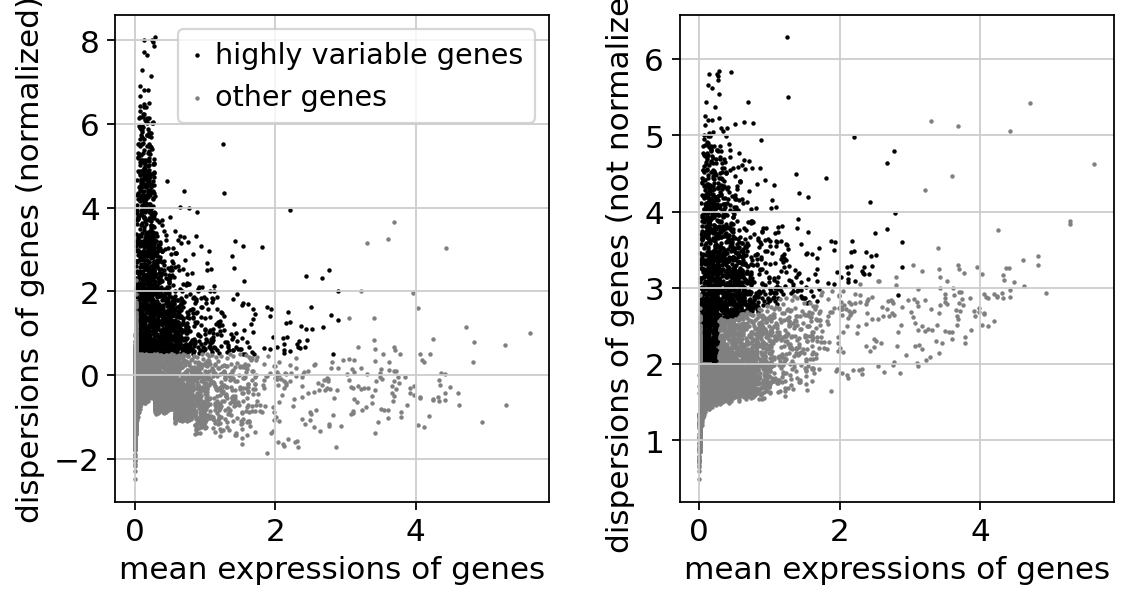

 Before  filtering for highly_variable genes : number of Cells 2638, number of genes 13714
 filter_HVG = True ... only highly_variable gene will be kept 
 AFTER  filtering for highly_variable genes: number of Cells 2638, number of genes 1838
####################################################  regress_out_anotated_QC_genes 
we are regressing out  total_counts True
we are regressing out  pct_counts_mt True
we are regressing out  pct_counts_ribo False
we are regressing out  pct_counts_malat1 False
we are regressing out  pct_counts_hb False
n_jobs= n_jobs=16


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


####################################################  Now running sc.pp.scale() Scale the data (each gene to unit variance)
####################################################  calc_cell_cycle_score
we are calc_cell_cycle_score True/Flase = True
running calc_cell_cycle_score(adata)
############# WARNING data should be scaled first if planing on regressing out cell cycle score
 there are 43 s_genes   54 g2m_genes  97 cell_cycle_genes
 there are 7 cell_cycle_genes in the dataset
       'ANLN', 'GAS2L3'],
      dtype='object')


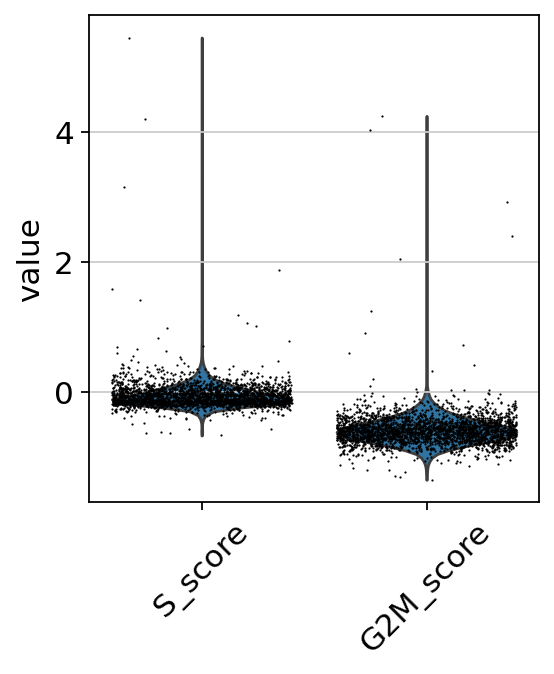

we are regressing out  cell_cycle_score True/Flase = False
####################################################  Principal component analysis
####################################################  Principal component analysis


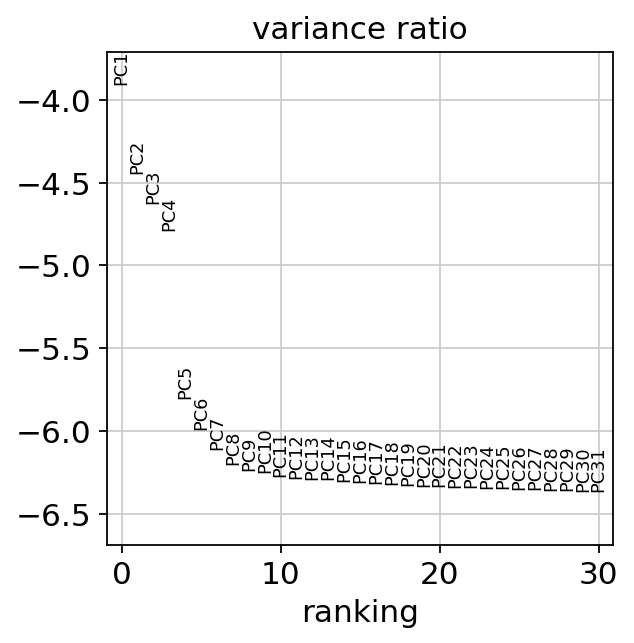

5.44 MB
None
5.44 MB
None


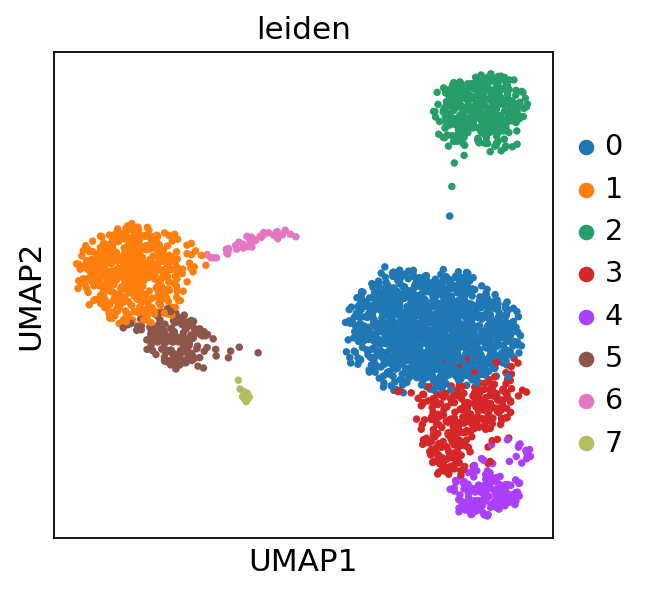

6.11 MB
None
 Average silhoutte score = 0.12597037851810455 for 8 clusters at leiden resolution of 0.9
6.13 MB
None


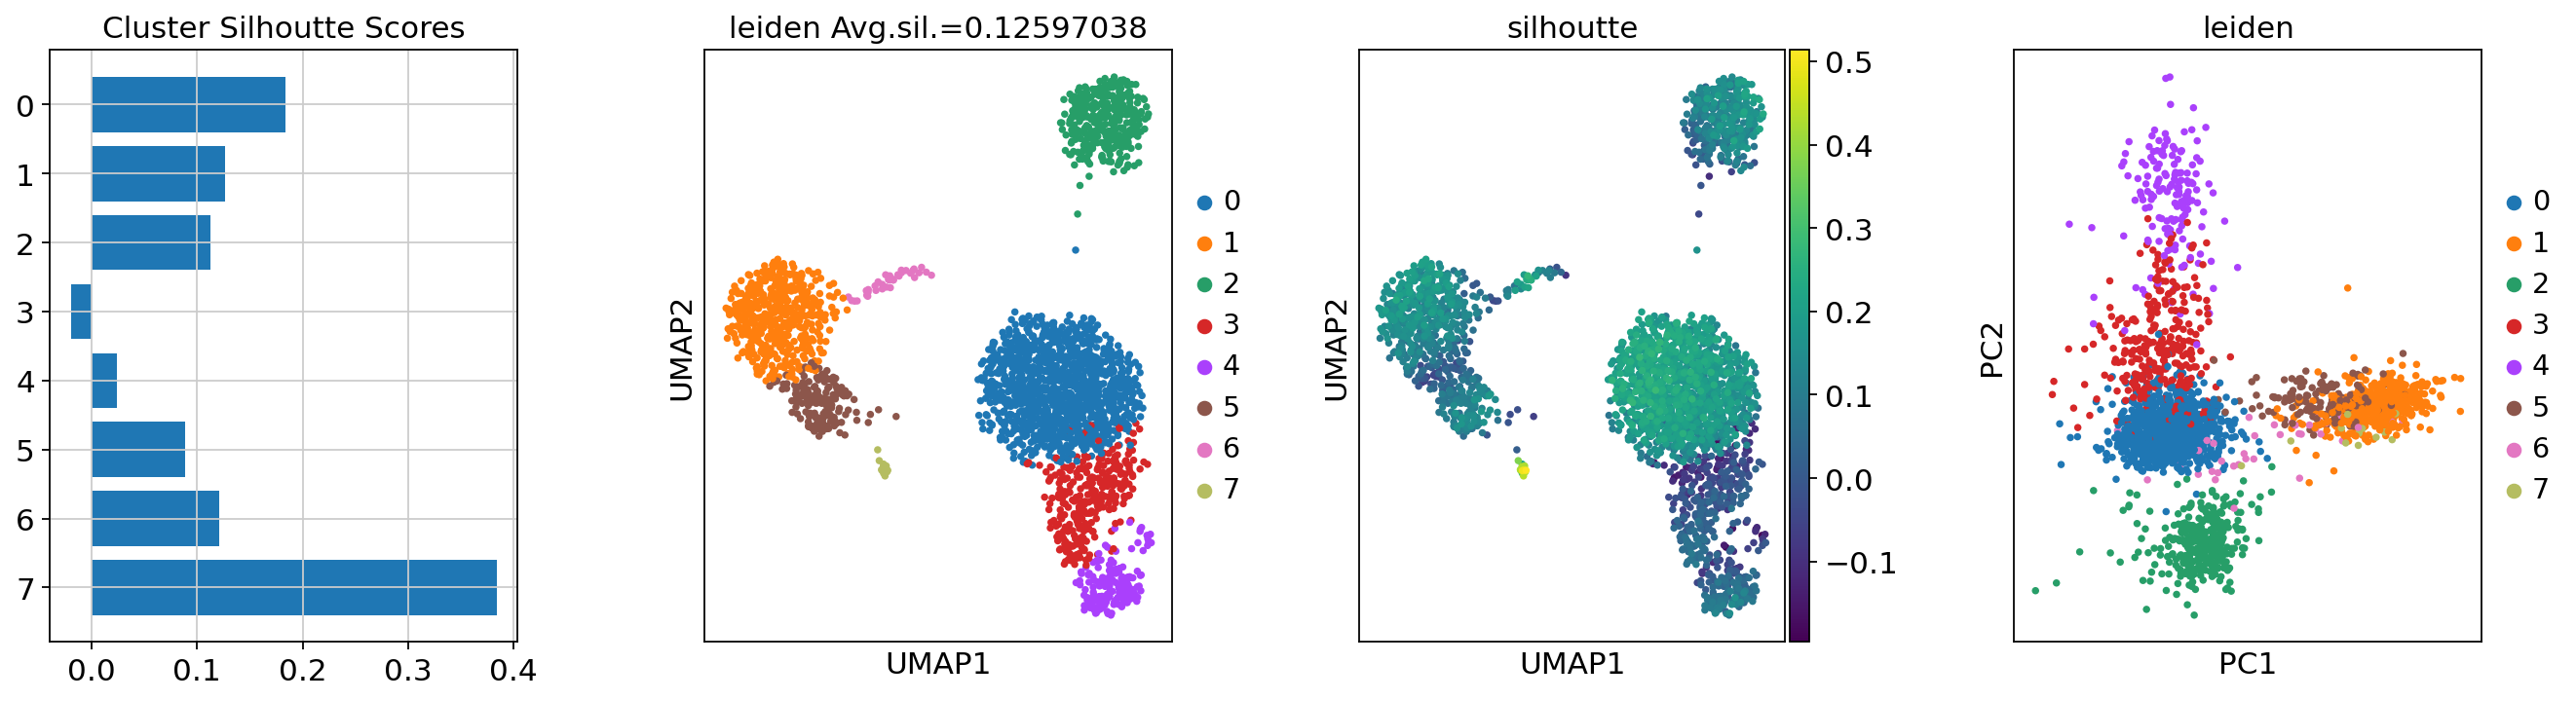

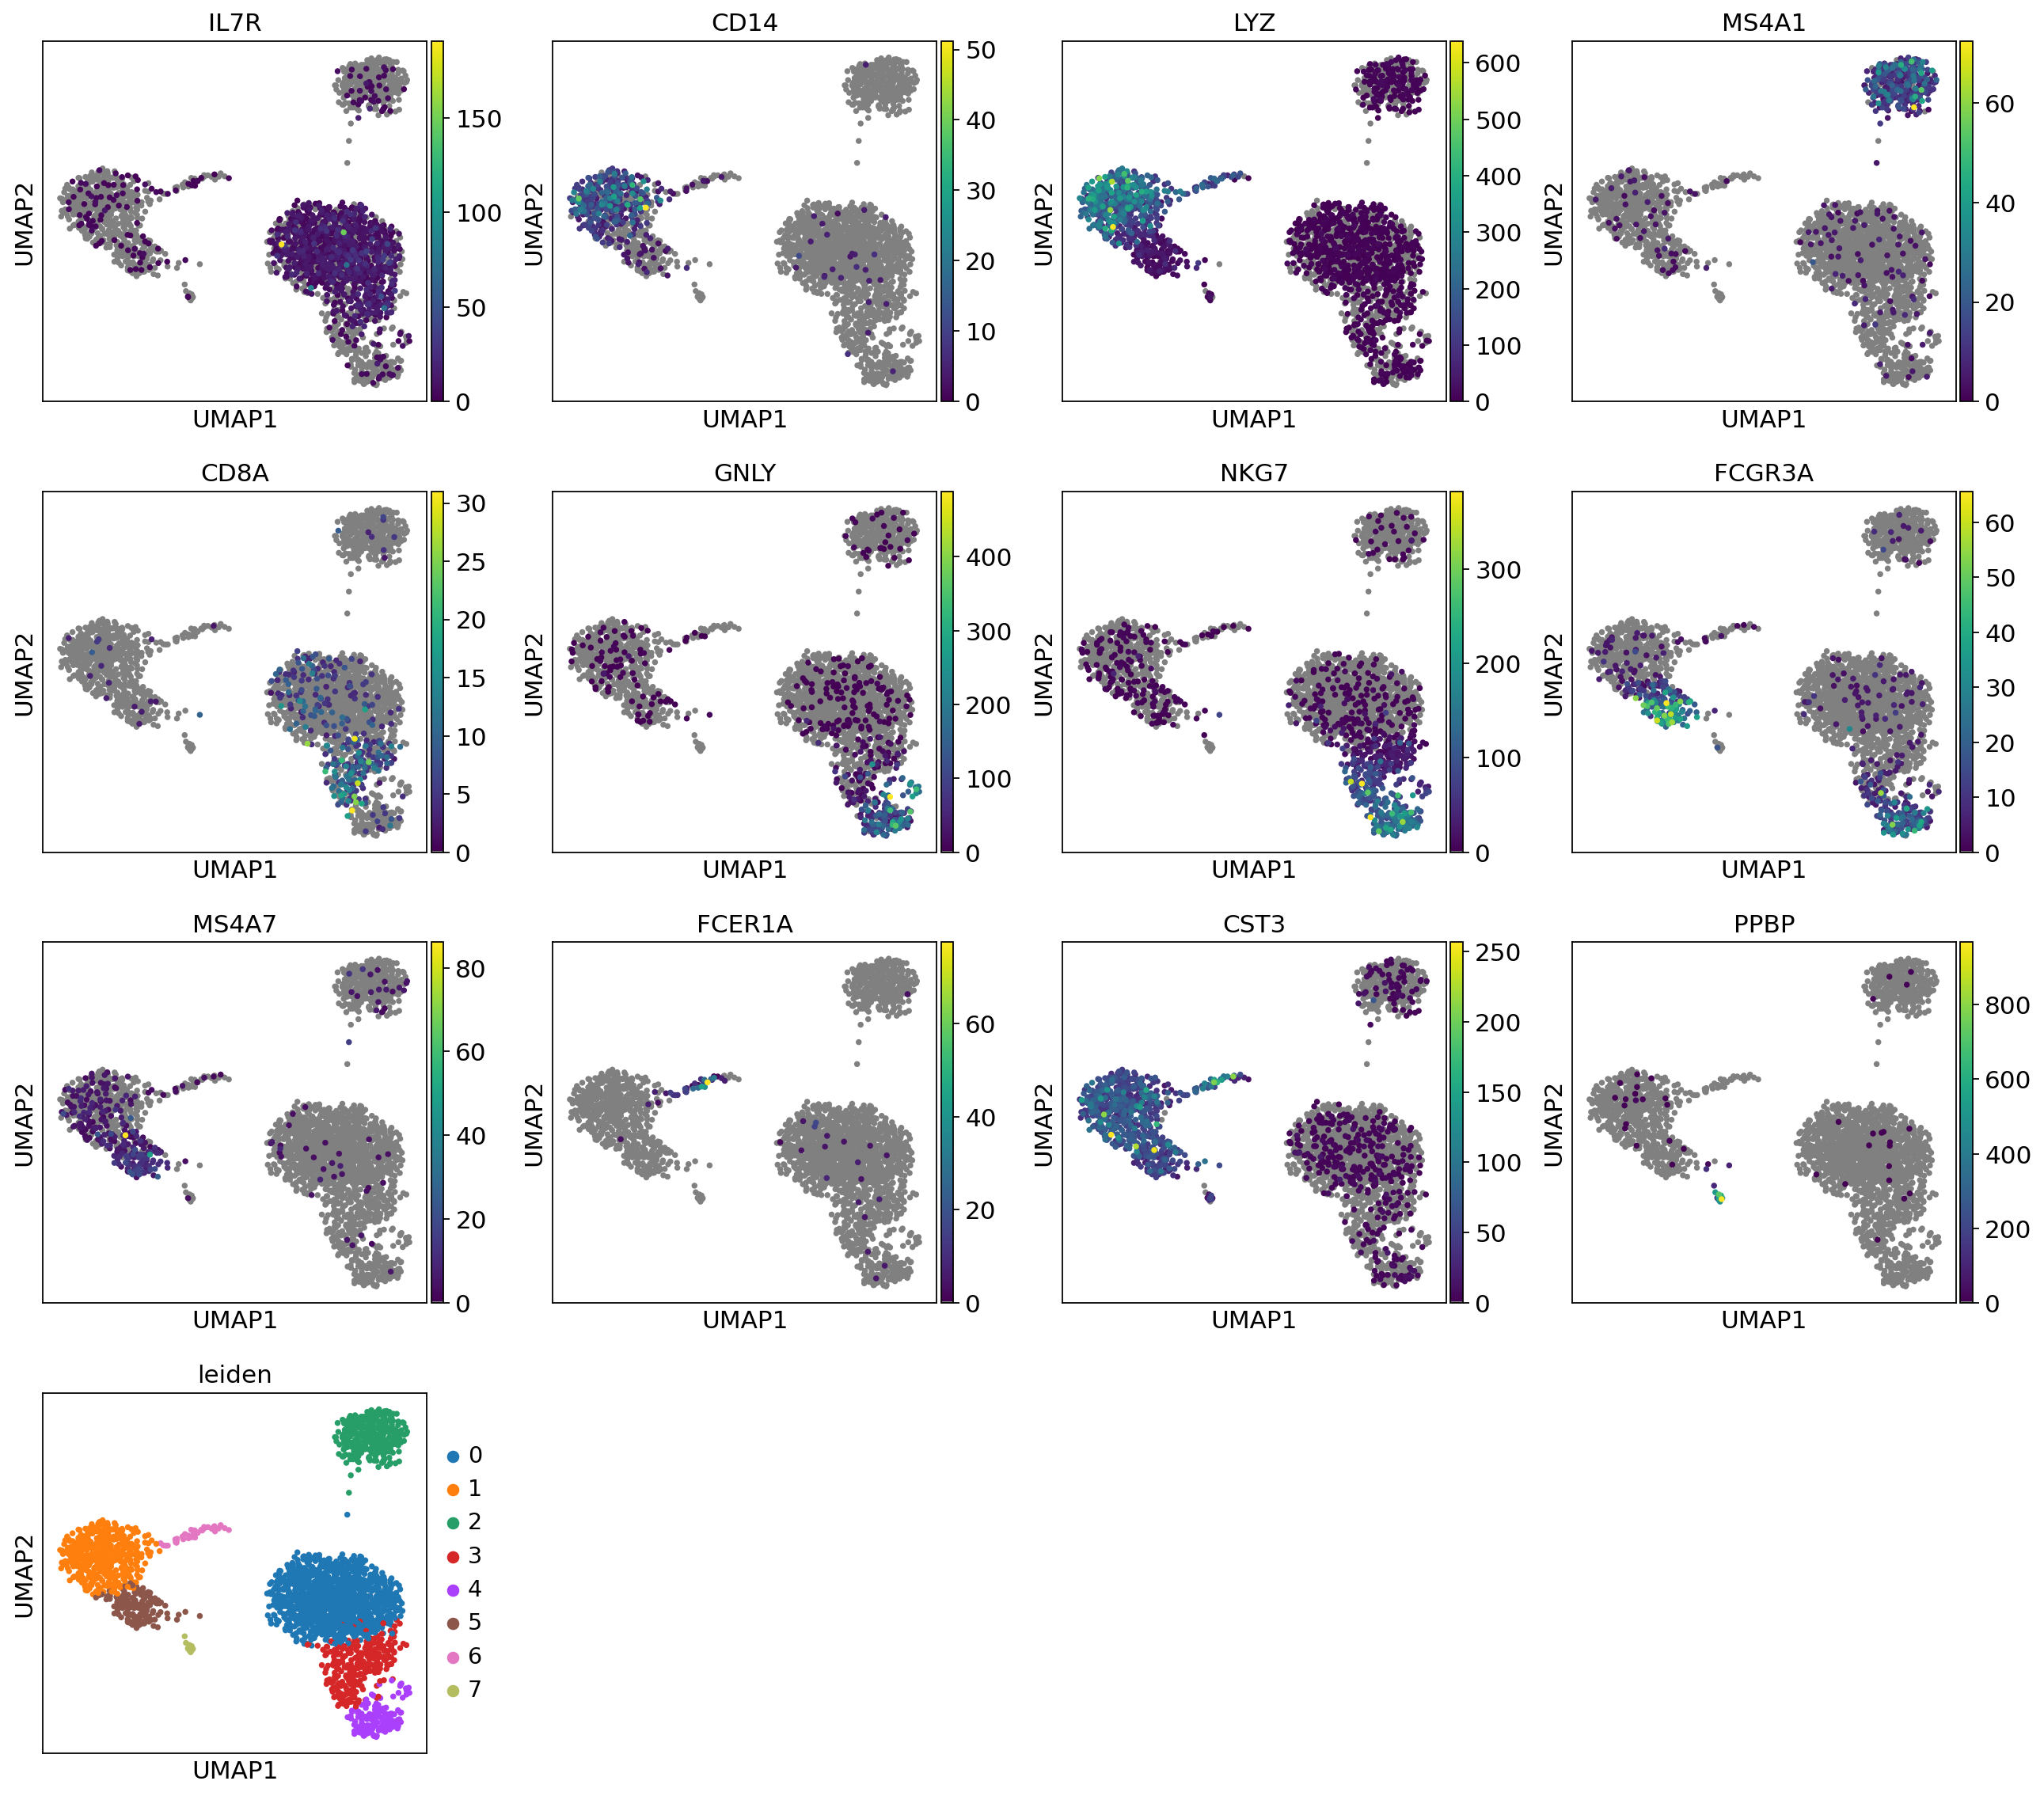

6.13 MB
None
CPU times: user 1min 21s, sys: 794 ms, total: 1min 21s
Wall time: 13.2 s


In [21]:
%%time
print(sctl.tl.print_size_in_MB(adata))
adata=sctl.pp.process2scaledPCA(adata,**adata.uns["parameters"])
print(sctl.tl.print_size_in_MB(adata))


print(sctl.tl.print_size_in_MB(adata))
sctl.pp.leiden_clustering(adata,**adata.uns["parameters"])
print(sctl.tl.print_size_in_MB(adata))

sctl.pl.silhouette_score_n_plot(adata,**adata.uns["parameters"])
print(sctl.tl.print_size_in_MB(adata))

## add a custom color map for the umaps to show zero expression as grey
# Custom colormap where zero values are represented by grey
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['gray'] + list(plt.cm.viridis(np.linspace(0, 1, 256))))

sc.pl.umap(adata, color=adata.uns["parameters"]['umap_marker_gene_list']+['leiden',
] , cmap=cmap)
print(sctl.tl.print_size_in_MB(adata))


In [22]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1', 'S_score', 'G2M_score', 'phase', 'leiden', 'silhoutte'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'parameters', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

6.28 MB
None


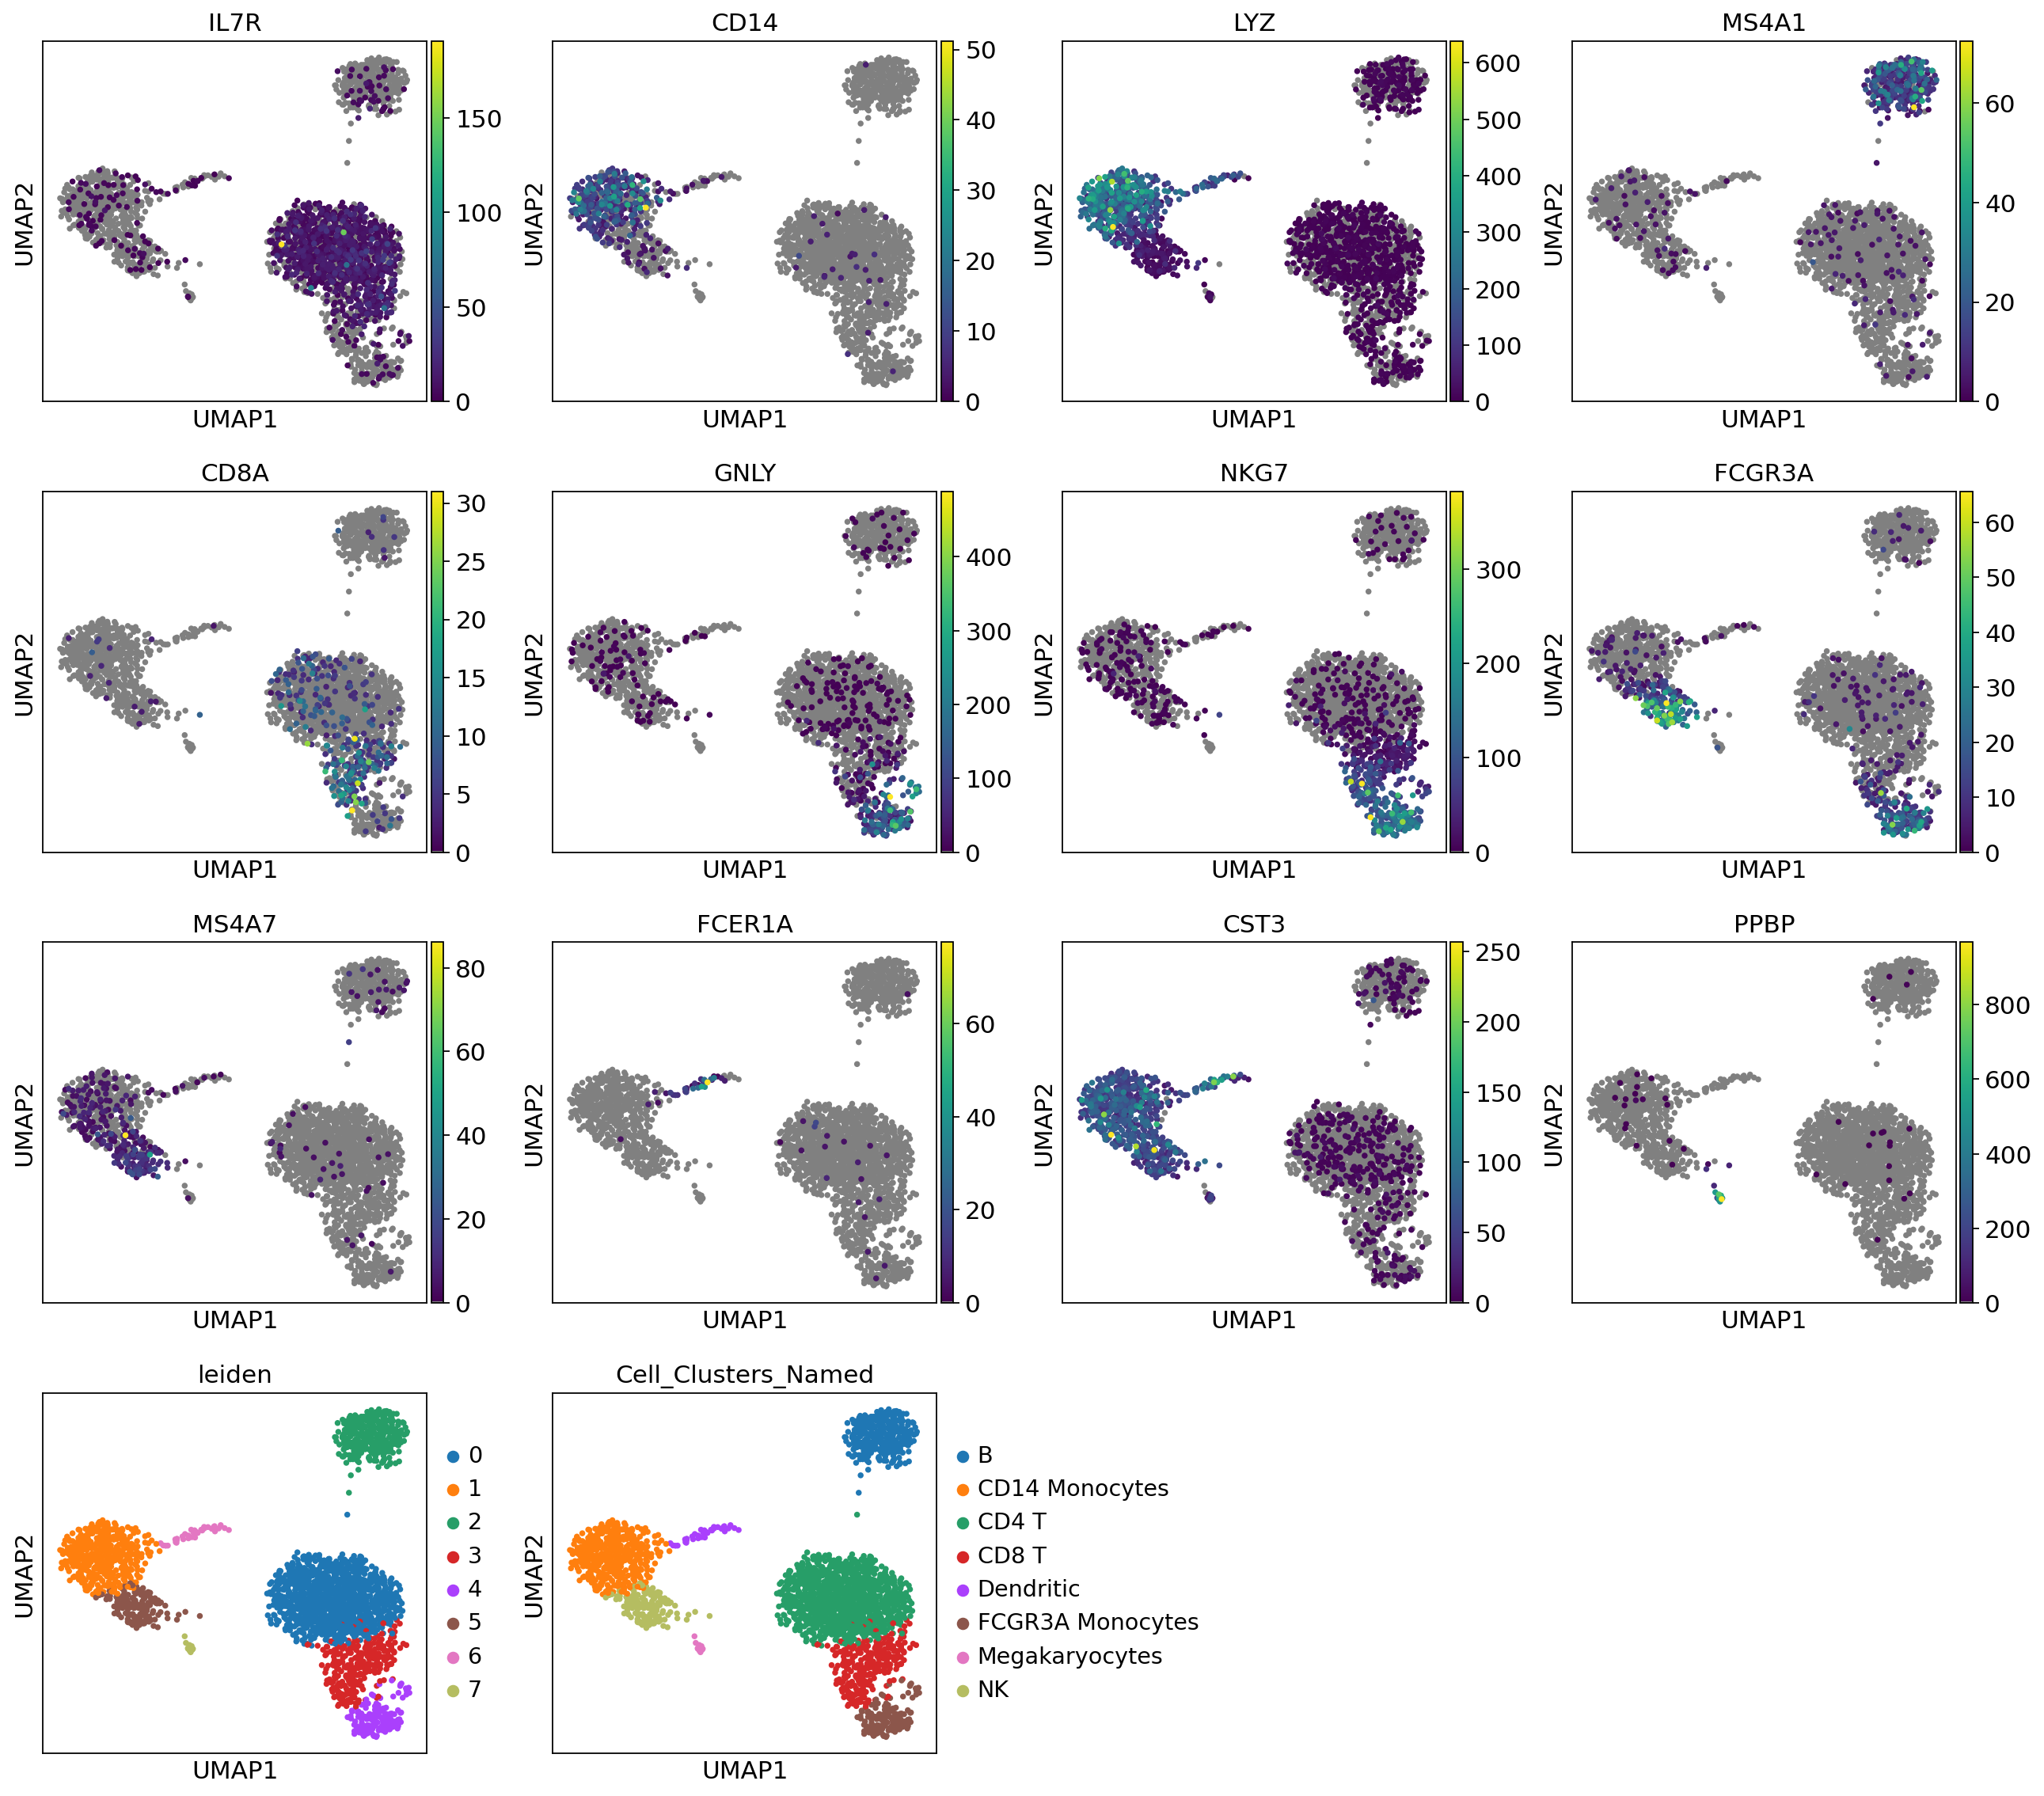

6.13 MB
None
CPU times: user 1.27 s, sys: 24 ms, total: 1.29 s
Wall time: 1.29 s


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1', 'S_score', 'G2M_score', 'phase', 'leiden', 'silhoutte', 'Cell_Clusters_Named'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'parameters', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell_Clusters_Named_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [23]:
%%time
adata.obs['leiden']=adata.obs['leiden'].astype(str)
sctl.pp.rename_leiden_clusters(adata,**adata.uns["parameters"])
print(sctl.tl.print_size_in_MB(adata))


sc.pl.umap(adata, color=adata.uns["parameters"]['umap_marker_gene_list']+['leiden','Cell_Clusters_Named'
] , cmap=cmap)
print(sctl.tl.print_size_in_MB(adata))
adata

In [24]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1', 'S_score', 'G2M_score', 'phase', 'leiden', 'silhoutte', 'Cell_Clusters_Named'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'parameters', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell_Clusters_Named_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## now do some Differential Expression Analysis and Gene Set Enrichment Analysis

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.1.0 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


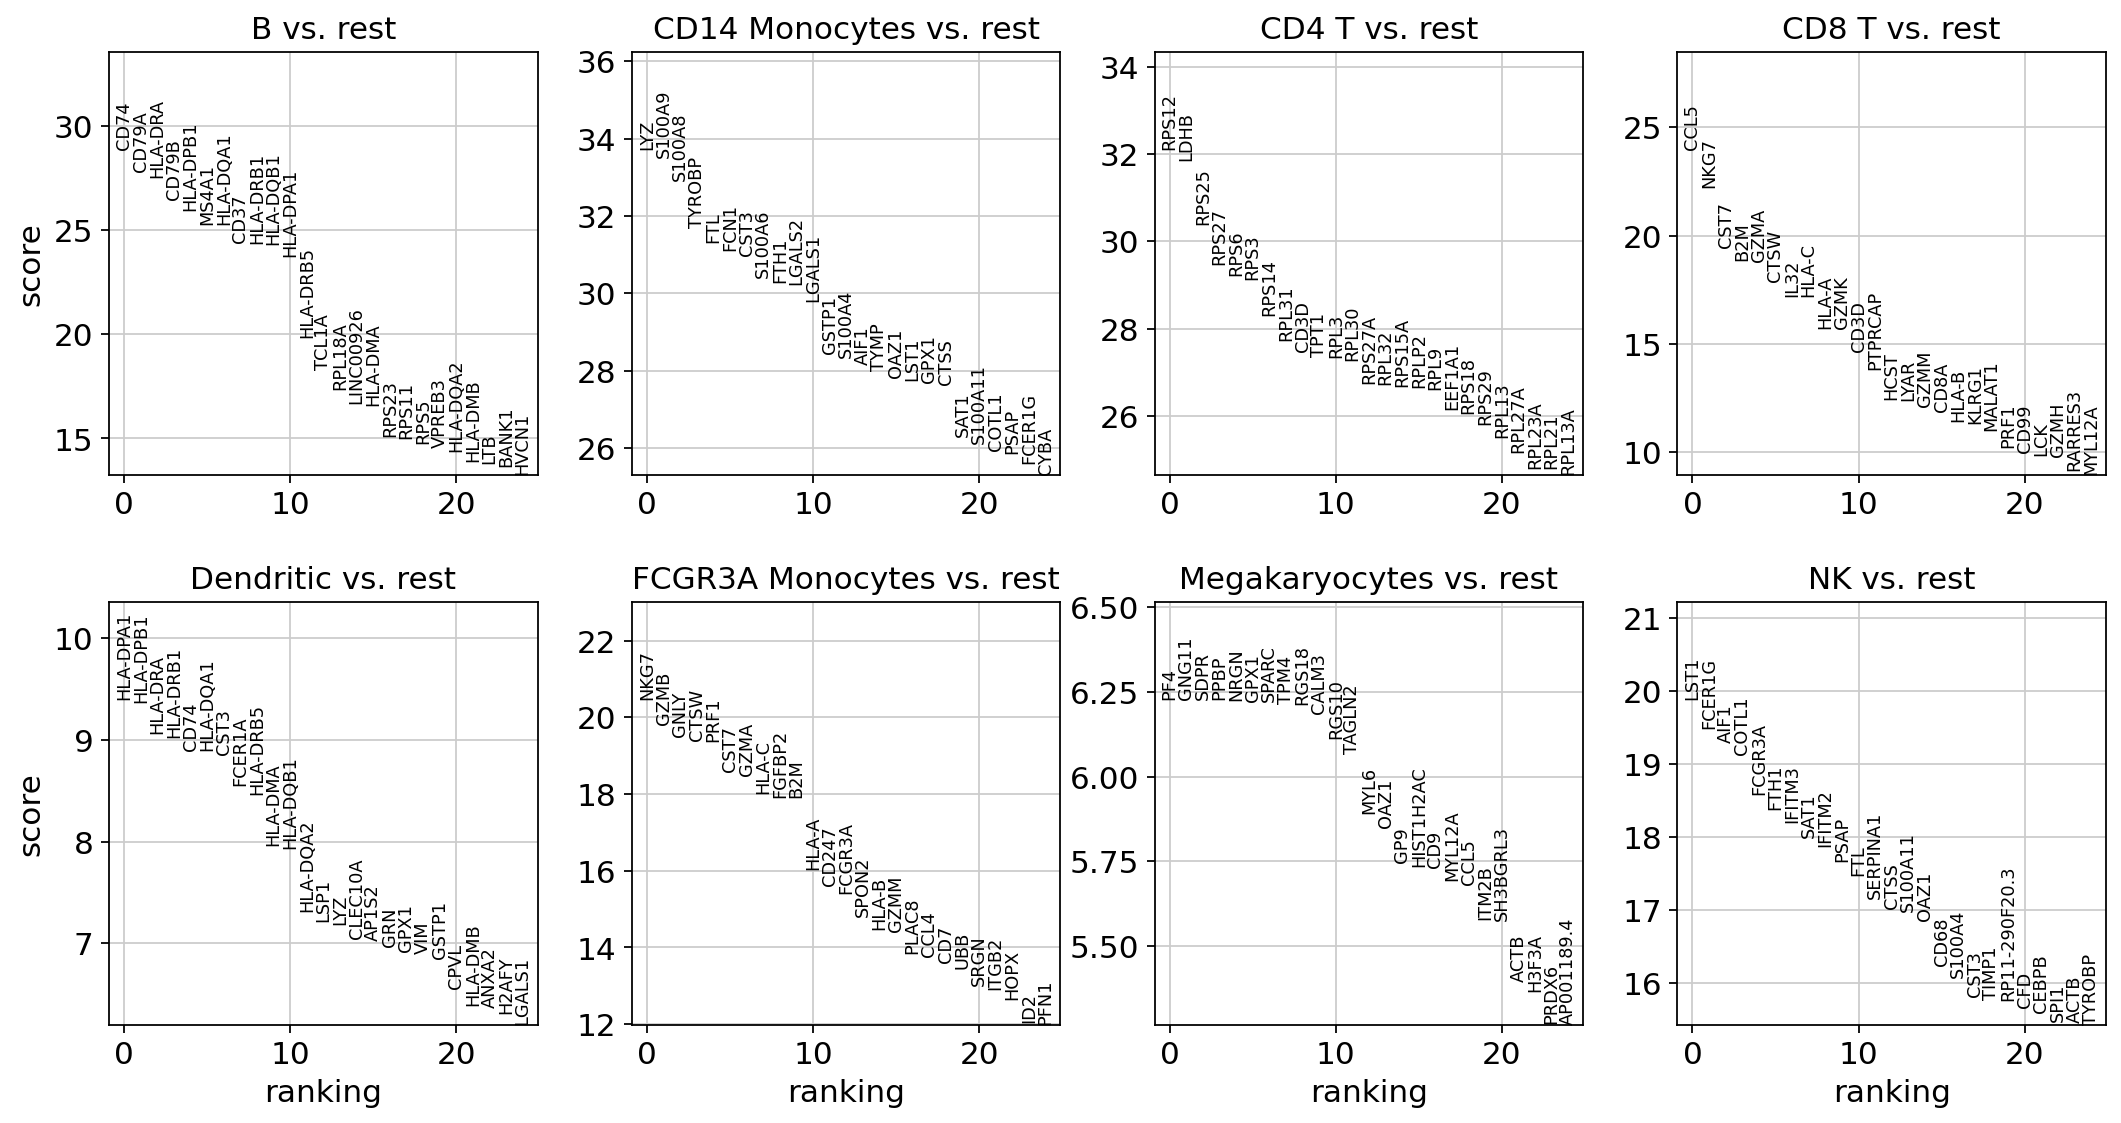

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


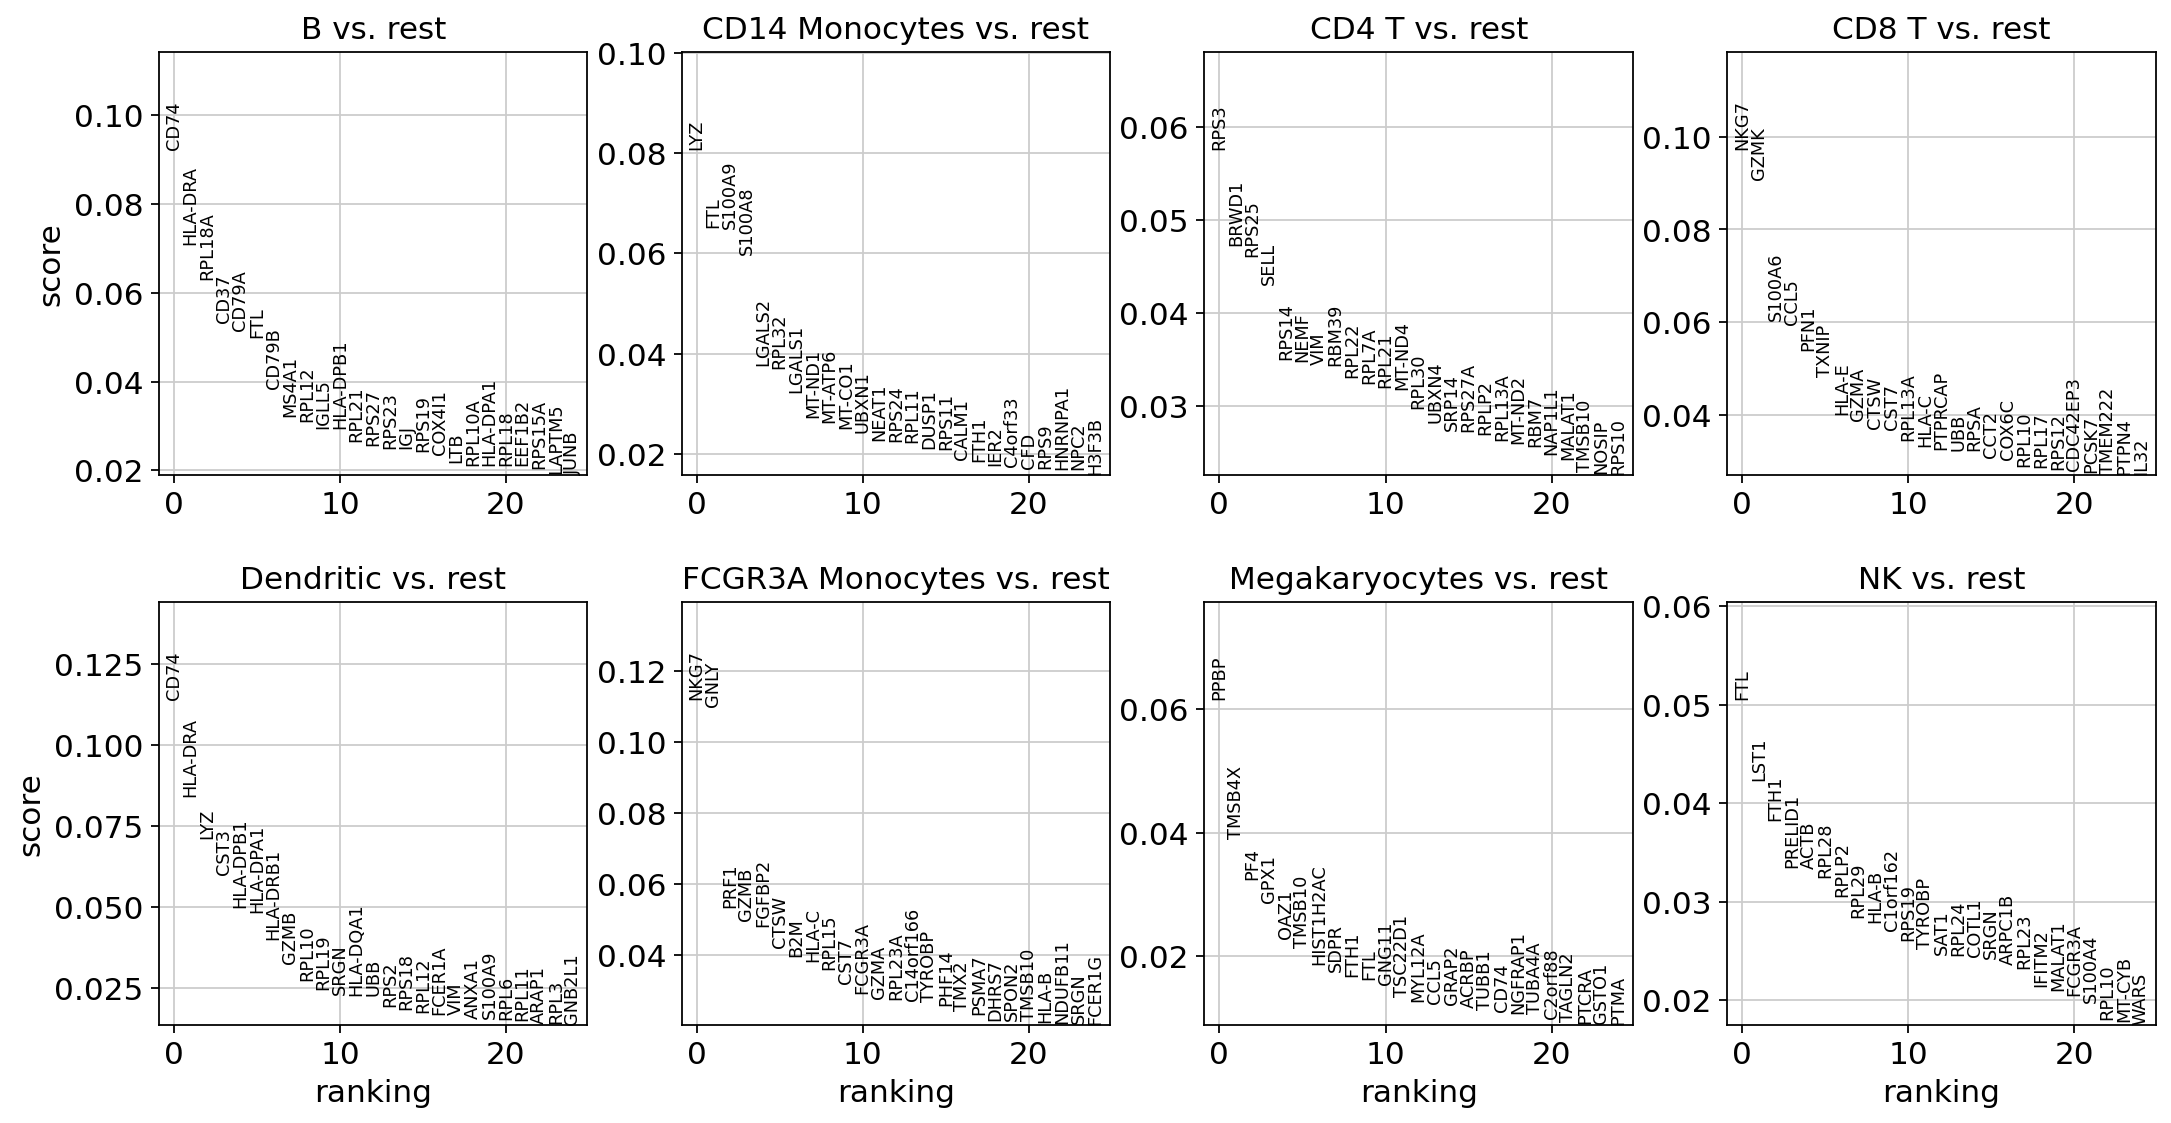

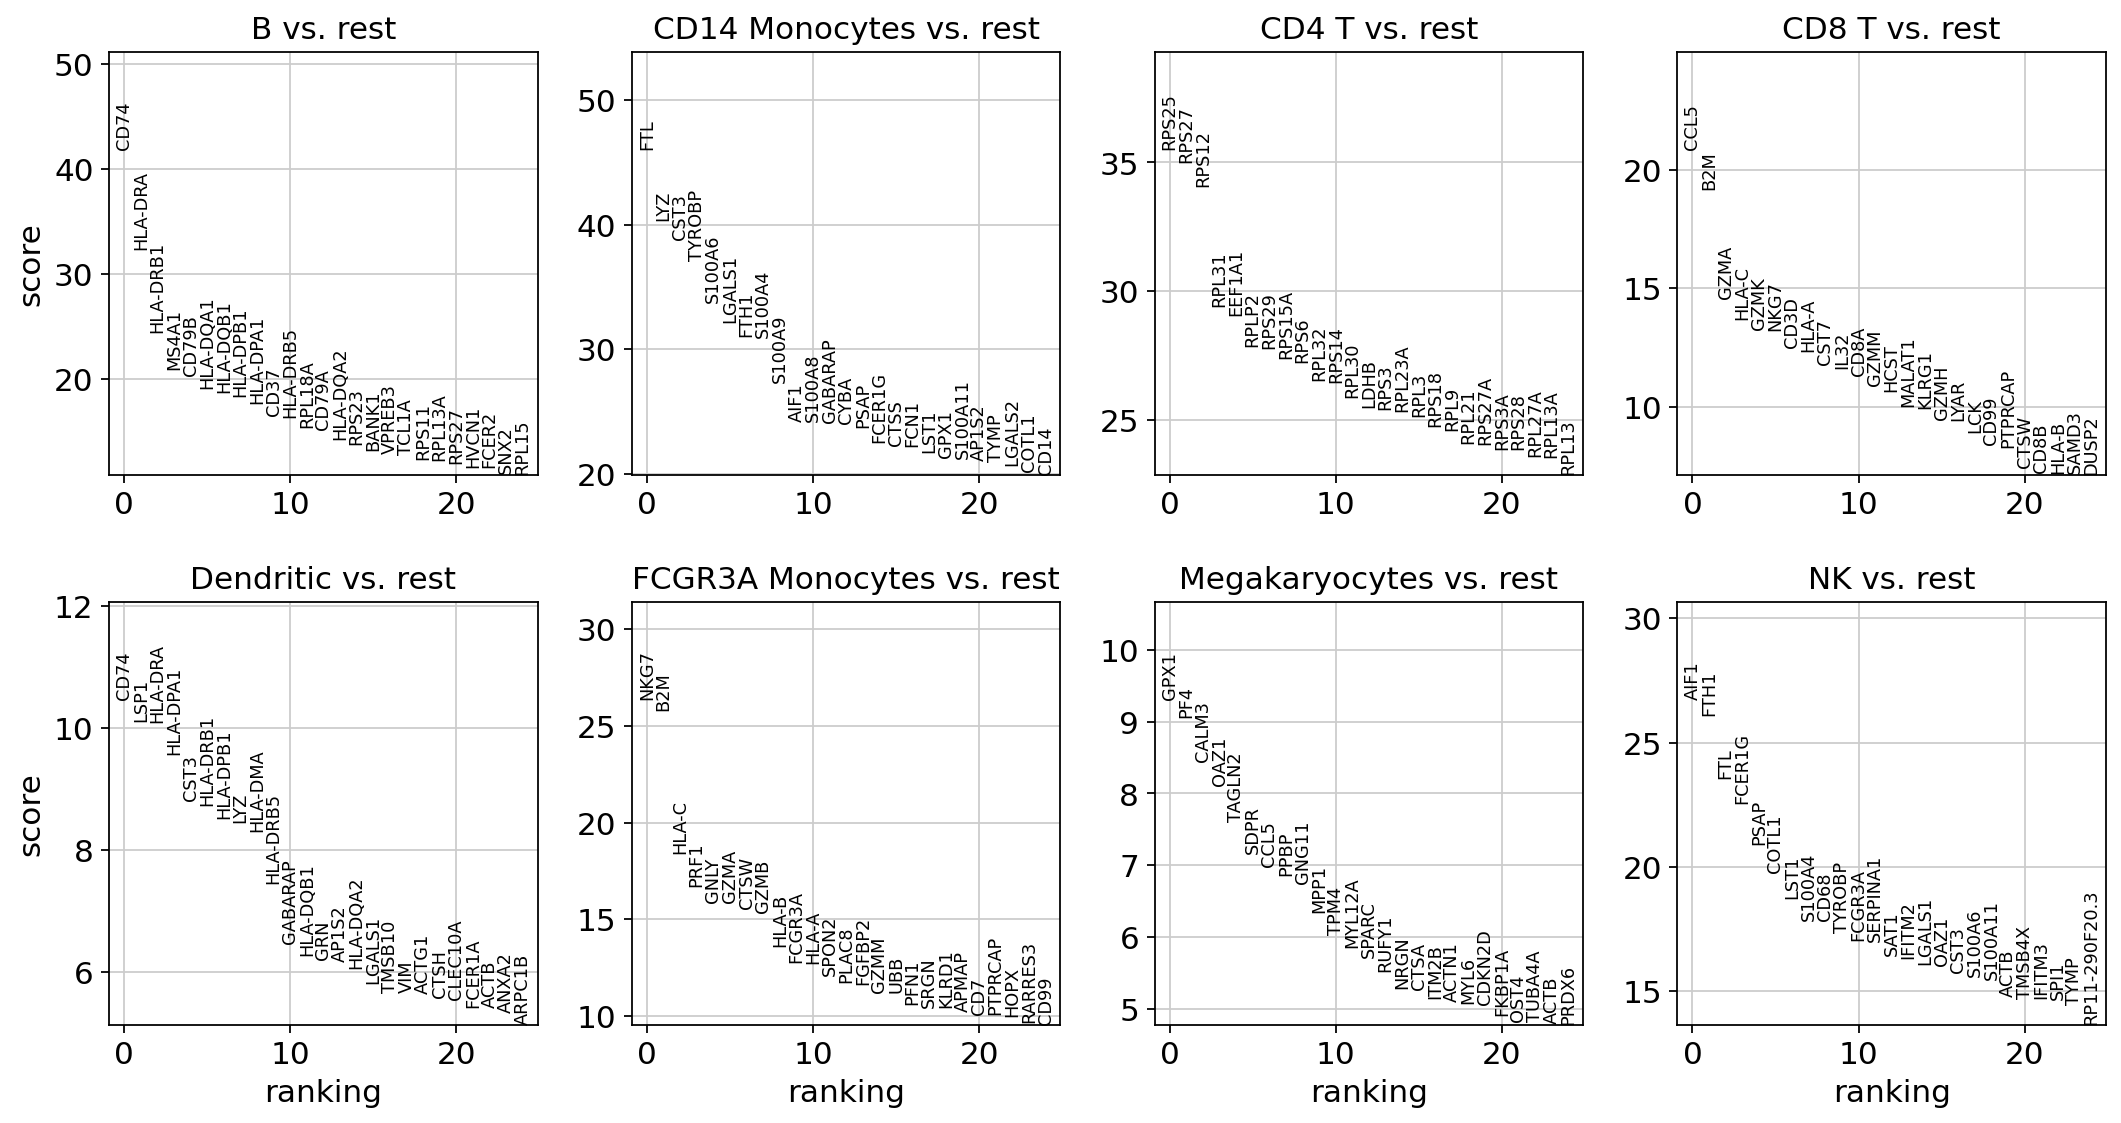

In [25]:
rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test = sctl.tl.rank_genes(adata,
               wilcox=True,logreg=True,t_test=True,rank_use_raw=True,obs_key="Cell_Clusters_Named",**parameters
                 )

In [26]:
rank_genes_groups_wilcox.head(4)

B_names   B_scores        B_pvals    B_pvals_adj  B_logfoldchanges  \
0     CD74  28.874624  2.487145e-183  3.410871e-179        187.259323   
1    CD79A  27.834099  1.677948e-170  1.150569e-166         34.850376   
2  HLA-DRA  27.533710  6.935111e-167  3.170270e-163        119.568779   
3    CD79B  26.463242  2.569135e-154  8.808280e-151         26.468523   

  CD14 Monocytes_names  CD14 Monocytes_scores  CD14 Monocytes_pvals  \
0                  LYZ              33.721020         2.844372e-249   
1               S100A9              33.517780         2.654880e-246   
2               S100A8              32.928020         8.731315e-238   
3               TYROBP              31.714521         9.799314e-221   

   CD14 Monocytes_pvals_adj  CD14 Monocytes_logfoldchanges  ...  \
0             3.900772e-245                     251.521912  ...   
1             1.820451e-242                     191.717056  ...   
2             3.991375e-234                     113.062645  ...   
3             3.359695e-217                      65.280083  ...   

  Megakaryocytes_names  Megakaryocytes_scores  Megakaryocytes_pvals  \
0                  PF4               6.228046          4.722886e-10   
1                GNG11               6.227681          4.733899e-10   
2                 SDPR               6.227681          4.733899e-10   
3                 PPBP               6.227316          4.744938e-10   

   Megakaryocytes_pvals_adj  Megakaryocytes_logfoldchanges NK_names  \
0              7.725969e-07                     244.833679     LST1   
1              7.725969e-07                     154.845978   FCER1G   
2              7.725969e-07                     123.847191     AIF1   
3              7.725969e-07                     673.905945    COTL1   

   NK_scores      NK_pvals  NK_pvals_adj  NK_logfoldchanges  
0  19.889820  4.985426e-88  6.837013e-84          65.767563  
1  19.485729  1.451002e-84  9.949522e-81          49.639309  
2  19.295675  5.839647e-83  2.669497e-79          52.189617  
3  19.136147  1.262714e-81  4.329216e-78          52.538490  

[4 rows x 40 columns]

In [27]:
rank_genes_groups_logreg.head(4)

B CD14 Monocytes  CD4 T   CD8 T Dendritic FCGR3A Monocytes  \
0     CD74            LYZ   RPS3    NKG7      CD74             NKG7   
1  HLA-DRA            FTL  BRWD1    GZMK   HLA-DRA             GNLY   
2   RPL18A         S100A9  RPS25  S100A6       LYZ             PRF1   
3     CD37         S100A8   SELL    CCL5      CST3             GZMB   

  Megakaryocytes       NK  
0           PPBP      FTL  
1         TMSB4X     LST1  
2            PF4     FTH1  
3           GPX1  PRELID1

In [28]:
rank_genes_groups_t_test.head(4)

B_names   B_scores        B_pvals    B_pvals_adj  B_logfoldchanges  \
0      CD74  41.891853  2.512188e-142  5.742024e-139        187.259323   
1   HLA-DRA  32.306232  7.125374e-111  7.516722e-108        119.568779   
2  HLA-DRB1  24.468054   1.350702e-81   7.409411e-79         33.929295   
3     MS4A1  20.904898   4.682478e-63   1.605388e-60         18.927225   

  CD14 Monocytes_names  CD14 Monocytes_scores  CD14 Monocytes_pvals  \
0                  FTL              46.021626         4.338669e-201   
1                  LYZ              40.338314         8.558484e-158   
2                 CST3              38.800312         1.692626e-165   
3               TYROBP              37.140057         2.851736e-151   

   CD14 Monocytes_pvals_adj  CD14 Monocytes_logfoldchanges  ...  \
0             1.190010e-197                     428.119507  ...   
1             8.383647e-155                     251.521912  ...   
2             1.934389e-162                      72.335770  ...   
3             2.300512e-148                      65.280083  ...   

  Megakaryocytes_names  Megakaryocytes_scores  Megakaryocytes_pvals  \
0                 GPX1               9.312696          7.670559e-07   
1                  PF4               9.062644          1.026017e-06   
2                CALM3               8.446024          2.131791e-06   
3                 OAZ1               8.114573          3.203154e-06   

   Megakaryocytes_pvals_adj  Megakaryocytes_logfoldchanges NK_names  \
0                  0.000002                     210.964172     AIF1   
1                  0.000003                     244.833679     FTH1   
2                  0.000005                      40.398705      FTL   
3                  0.000008                     151.854446   FCER1G   

   NK_scores      NK_pvals  NK_pvals_adj  NK_logfoldchanges  
0  26.747816  1.006606e-62  3.834608e-60          52.189617  
1  26.114120  5.521353e-62  1.941534e-59         332.263092  
2  23.574633  4.156073e-56  1.390156e-53         417.040588  
3  22.549894  7.437662e-52  2.170215e-49          49.639309  

[4 rows x 40 columns]

### now some Gene set enrichment analysis based on the top differentially expressed genes
Check the directory for the results of the GSEA analysis

In [29]:
sctl.tl.GSEA_enrichr_all_clusters(test_library_names=['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'],
 top_nth=10,**parameters )

logreg: the full_table  is 13714 genes long by 8 columns for 8 clusters
logreg: the foreground list is 1371 genes long
<CLUSTER 0> for logreg gene rank top 3 background genes ['CD74', 'HLA-DRA', 'RPL18A'], bottom 3 background genes ['SELL', 'ACTB', 'LYZ'] 
<CLUSTER 0> for logreg gene rank top 3 foreground genes ['CD74', 'HLA-DRA', 'RPL18A'], bottom 3 foreground genes ['ZNF512', 'SPG21', 'TFEC'] 
<CLUSTER 1> for logreg gene rank top 3 background genes ['LYZ', 'FTL', 'S100A9'], bottom 3 background genes ['RPL29', 'PRELID1', 'RPL28'] 
<CLUSTER 1> for logreg gene rank top 3 foreground genes ['LYZ', 'FTL', 'S100A9'], bottom 3 foreground genes ['CASC3', 'ZNF205', 'VPS36'] 
<CLUSTER 2> for logreg gene rank top 3 background genes ['RPS3', 'BRWD1', 'RPS25'], bottom 3 background genes ['HLA-DRA', 'CD74', 'NKG7'] 
<CLUSTER 2> for logreg gene rank top 3 foreground genes ['RPS3', 'BRWD1', 'RPS25'], bottom 3 foreground genes ['USP22', 'TNK2', 'LTBP4'] 
<CLUSTER 3> for logreg gene rank top 3 backgrou

### END  # use megadesk_single_cell package functions scanpy wrappers

# do processing using scanpy fucnitons (AspenNeuro_singlecell functions unwraped )

In [30]:
adata


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1', 'S_score', 'G2M_score', 'phase', 'leiden', 'silhoutte', 'Cell_Clusters_Named'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'parameters', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell_Clusters_Named_colors', 'wilcoxon', 'logreg', 't-test'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [31]:
adata_raw_counts

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    uns: 'parameters'

In [32]:
adata=adata_raw_counts.copy()
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    uns: 'parameters'

In [33]:
# turn the dictionary values into variables

locals().update(adata.uns["parameters"])


In [34]:
print(f'number of Cells BEFORE Basic Filtering : {adata.n_obs}')
sc.pp.filter_cells(adata, min_genes=filter_cells_min_genes,)  #min_genes=over_n_genes_bycounts
print(f'Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_genes)  Cells remaining : {adata.n_obs}')
sc.pp.filter_cells(adata,min_counts=filter_cells_min_counts,)  # cells / observations must have min # of coutns
print(f'Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_counts)  Cells remaining : {adata.n_obs}')
sc.pp.filter_genes(adata, min_cells=filter_genes_min_cells ) #genes must be present in min # of cells / observations
print(f'Filtering genes pp.filter_genes(adata, min_cells=filter_genes_min_cells)  Genes remaining : {adata.n_vars}')
sc.pp.filter_genes(adata, min_counts=filter_genes_min_counts ) #genes must have min # of counts for gene to be kept
print(f'Filtering genes pp.filter_genes(adata, min_cells=filter_genes_min_counts)  Genes remaining :  {adata.n_vars}')

number of Cells BEFORE Basic Filtering : 2700
Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_genes)  Cells remaining : 2700
Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_counts)  Cells remaining : 2700
Filtering genes pp.filter_genes(adata, min_cells=filter_genes_min_cells)  Genes remaining : 13714
Filtering genes pp.filter_genes(adata, min_cells=filter_genes_min_counts)  Genes remaining :  13714


<Axes: ylabel='value'>

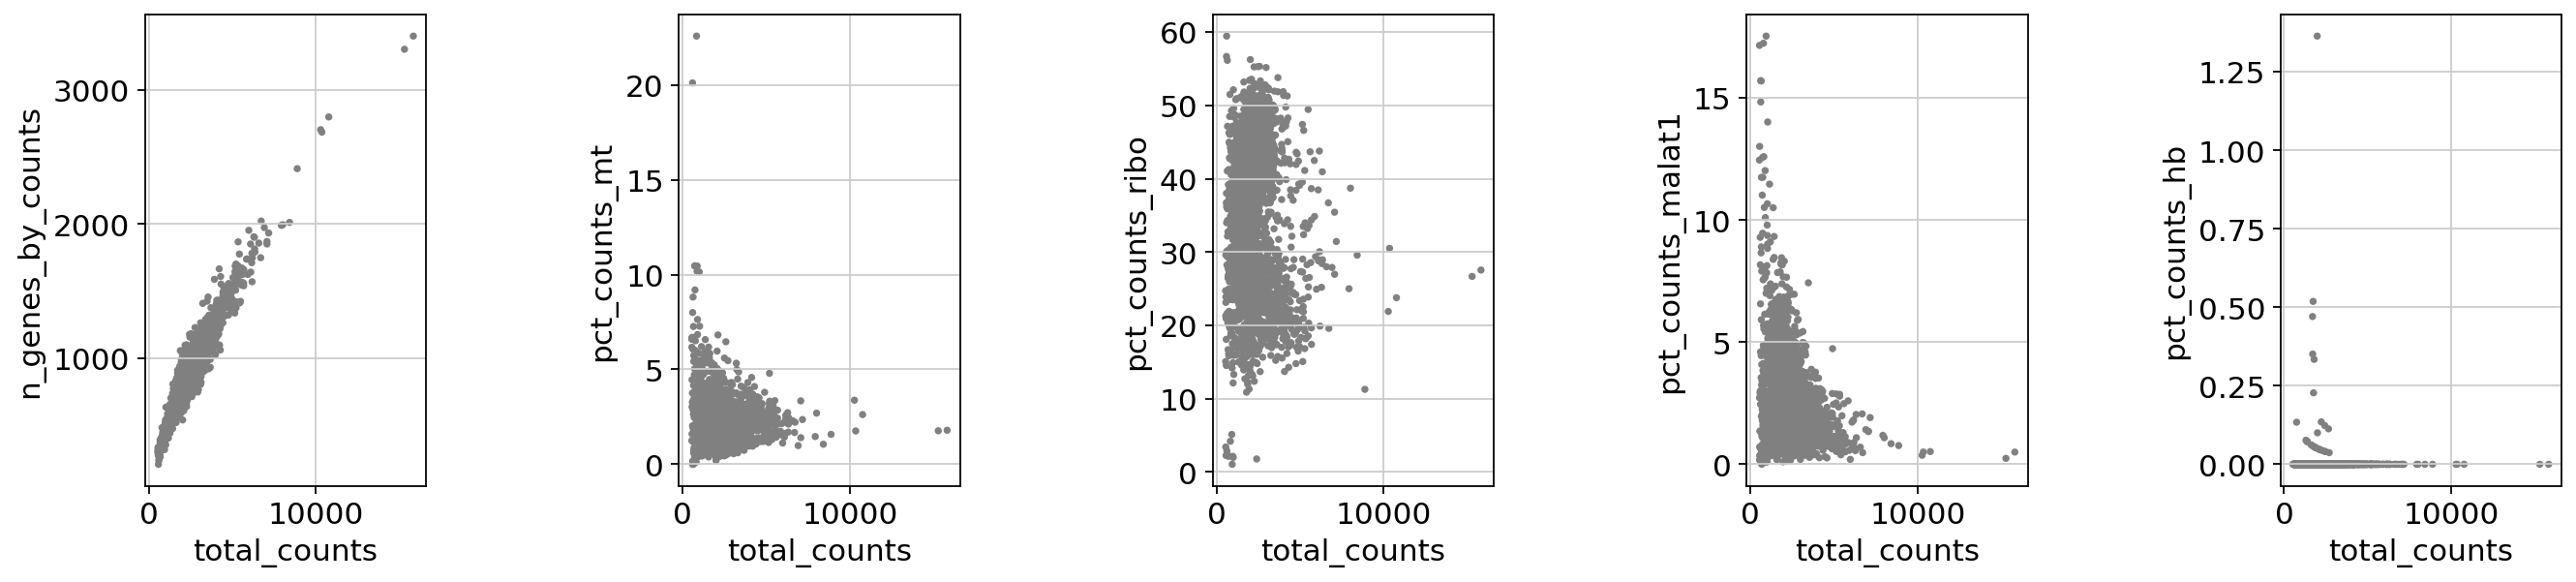

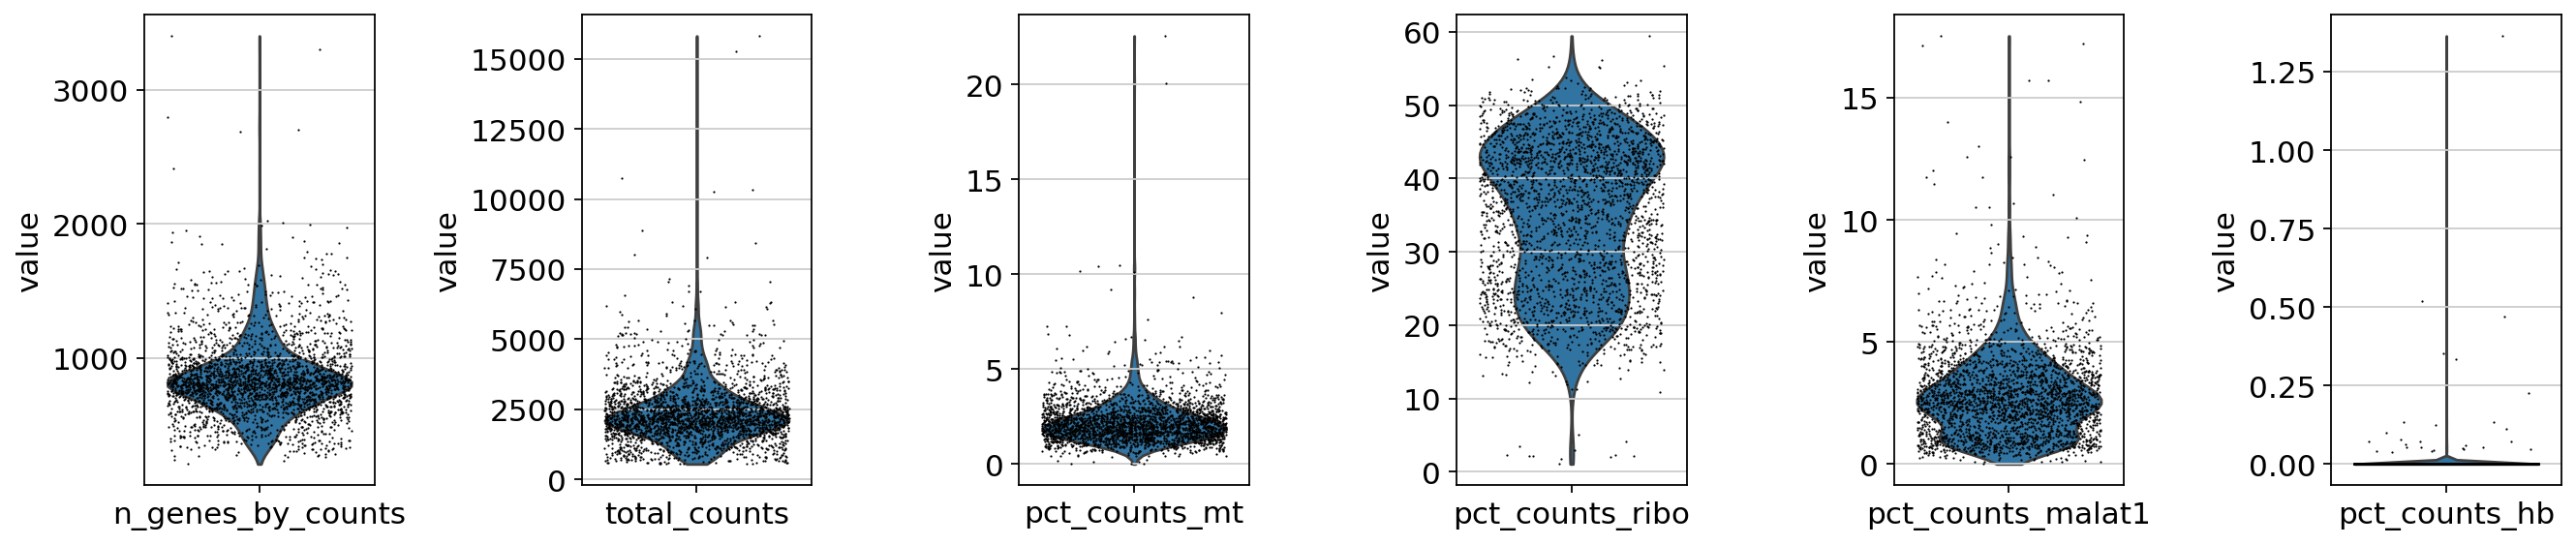

In [35]:

### annotate_QC_genes and calculate_qc_metrics functions

##  annotate_n_view_adata_raw_counts(adata)

# def annotate_QC_genes(adata):
adata.var['mt'] = adata.var_names.str.startswith("MT-")  # mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # ribosomal genes genes as 'ribo'
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)(S)]")) & ~adata.var_names.str.contains(("HBEGF")) 
# "^HB[^(P)" changed to "^HB[^(P)(S)" and  & ~adata_test.var_names.str.contains(("HBEGF")) added to remove HBS1L and HBEGF which are NOT memoglobin genes
adata.var['malat1'] = adata.var_names.str.contains(("MALAT1"))  # MALAT1 genes as 'malat1'

# def calculate_qc_metrics(adata):
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) # mitocohndrial  genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True) # ribosomal genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['hb'], percent_top=None, log1p=False, inplace=True) # hemoglobin genes.
sc.pp.calculate_qc_metrics(adata, qc_vars=['malat1'], percent_top=None, log1p=False, inplace=True) # MALAT1 gene.

# def plot_QC_metrics_scatter(adata):
figQC, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1 ,5,figsize=(20,4), gridspec_kw={'wspace':0.9})
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax=ax1, show=False) # plot number of dected genes vs total counts 
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',ax=ax2, show=False) #percent mt counts vs total counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo',ax=ax3, show=False) #percent ribo counts vs total counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_malat1',ax=ax4, show=False) #percent HB counts vs total count
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb',ax=ax5, show=False) #percent HB counts vs total counts 

#def plot_QC_metrics_violin(adata):
fig1, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1 ,6,figsize=(20,4), gridspec_kw={'wspace':0.9})
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4,ax=ax1, show=False)
sc.pl.violin(adata, ['total_counts'], jitter=0.4 ,ax=ax2, show=False)
sc.pl.violin(adata, [ 'pct_counts_mt'], jitter=0.4,ax=ax3, show=False) # mitocohndrial  genes
sc.pl.violin(adata, [ 'pct_counts_ribo'], jitter=0.4,ax=ax4, show=False) # ribosomal genes
sc.pl.violin(adata, [ 'pct_counts_malat1'], jitter=0.4,ax=ax5, show=False) # hemoglobin genes.
sc.pl.violin(adata, [ 'pct_counts_hb'], jitter=0.4,ax=ax6, show=False) # hemoglobin genes.

In [36]:
print(f' {filter_ncount} keep cells with less than {n_genes_bycounts} (n_genes_bycounts) dected genes ')

print(f' {filter_pct_mt} keep cells with less than {percent_mt} (percent_mt) mitochondiral gene counts ')
print(f' {filter_pct_mt} keep cells with greater than {over_percent_mt} (percent_mt) mitochondiral gene counts ')

print(f' {filter_pct_ribo} keep cells with less than {percent_ribo} (percent_ribo) ribosomal protein gene counts ')
print(f' {filter_pct_ribo} keep cells with greater than {over_percent_ribo} (percent_ribo) ribosomal protein gene counts ')

print(f' {filter_pct_hb} keep cells with less than {percent_hb} (percent_hb) hemoglobin protein gene counts ')
print(f' {filter_pct_hb} keep cells with greater than {over_percent_hb} (percent_ribo) ribosomal protein gene counts ')

print(f' {filter_pct_malat1} keep cells with less than {percent_malat1} (percent_hb) hemoglobin protein gene counts ')
print(f' {filter_pct_malat1} keep cells with greater than {over_percent_malat1} (percent_ribo) ribosomal protein gene counts ')

# Actually do the filtering by slicing the `AnnData` object.
print(f'number of Cells BEFORE pct Filtering : {adata.n_obs}')
if filter_ncount ==True:
    adata = adata[adata.obs.n_genes_by_counts <= n_genes_bycounts, :].copy()  # by n_genes_bycounts
    print(f'number of Cells AFTER n_genes_bycounts Filtering : {adata.n_obs}')
if filter_pct_mt ==True:
    adata = adata[adata.obs.pct_counts_mt <= percent_mt, :].copy()   # by percent_mt
    print(f'number of Cells AFTER percent_mt Filtering : {adata.n_obs}')
    adata = adata[adata.obs.pct_counts_mt >= over_percent_mt, :].copy()    # by percent_mt
    print(f'number of Cells AFTER over_percent_mt Filtering : {adata.n_obs}')
if filter_pct_ribo ==True:
    adata = adata[adata.obs.pct_counts_ribo <= percent_ribo, :].copy()   # by percent_ribo
    print(f'number of Cells AFTER percent_ribo Filtering : {adata.n_obs}')
    adata = adata[adata.obs.pct_counts_ribo >= over_percent_ribo, :].copy()    # by percent_ribo
    print(f'number of Cells AFTER over_percent_ribo Filtering : {adata.n_obs}')
if filter_pct_hb ==True:
    adata = adata[adata.obs.pct_counts_hb <= percent_hb, :].copy()    # by percent_hb
    print(f'number of Cells AFTER percent_hb Filtering : {adata.n_obs}')
    adata = adata[adata.obs.pct_counts_hb >= over_percent_hb, :].copy()    # by percent_hb
    print(f'number of Cells AFTER over_percent_hb Filtering : {adata.n_obs}')
if filter_pct_malat1 ==True:
    adata = adata[adata.obs.pct_counts_malat1 <= percent_malat1, :].copy()    # by percent_hb
    print(f'number of Cells AFTER percent_malat1 Filtering : {adata.n_obs}')
    adata = adata[adata.obs.pct_counts_malat1 >= over_percent_malat1, :].copy()    # by percent_hb
    print(f'number of Cells AFTER over_percent_malat1 Filtering : {adata.n_obs}')        


 True keep cells with less than 2500 (n_genes_bycounts) dected genes 
 True keep cells with less than 5 (percent_mt) mitochondiral gene counts 
 True keep cells with greater than 0 (percent_mt) mitochondiral gene counts 
 False keep cells with less than 100 (percent_ribo) ribosomal protein gene counts 
 False keep cells with greater than 0 (percent_ribo) ribosomal protein gene counts 
 False keep cells with less than 100 (percent_hb) hemoglobin protein gene counts 
 False keep cells with greater than 0 (percent_ribo) ribosomal protein gene counts 
 False keep cells with less than 100 (percent_hb) hemoglobin protein gene counts 
 False keep cells with greater than 0 (percent_ribo) ribosomal protein gene counts 
number of Cells BEFORE pct Filtering : 2700
number of Cells AFTER n_genes_bycounts Filtering : 2695
number of Cells AFTER percent_mt Filtering : 2638
number of Cells AFTER over_percent_mt Filtering : 2638


In [37]:



### Remove gene sets  on off switches
print(f'####################################################  remove_genes')
print(f'remove_MALAT1 {remove_MALAT1}')
print(f'remove_MT {remove_MT}')
print(f'remove_HB {remove_HB}')
print(f'remove_RP_SL {remove_RP_SL}')
print(f'remove_MRP_SL {remove_MRP_SL} ')


print(f' BEFORE filtering for specific gene : number of Cells {adata.n_obs}, number of genes {adata.n_vars}')

nothing = adata.var_names.str.startswith('NO_GENES_HAVE_THIS_NAME')
remove = np.add(nothing, nothing)
print(len((nothing)))

if remove_MALAT1==True:
    malat1 = adata.var_names.str.startswith('MALAT1')
    remove = np.add(remove, malat1)
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.

if remove_MT==True:
    mito_genes = adata.var_names.str.startswith('MT-')
    remove = np.add(remove,mito_genes)
if remove_HB==True:
    hb_genes = (adata.var_names.str.startswith('HB')& ~adata.var_names.str.contains(("HBEGF"))  & ~adata.var_names.str.contains(("HBS1L"))  & ~adata.var_names.str.contains(("HBP1"))) # HBEGF,HBS1L, HBP1 not a hemeoglobin genes 
    remove = np.add(remove,hb_genes)
if remove_RP_SL==True:
    RP_SL_genes = adata.var_names.str.startswith(("RPS","RPL"))
    remove = np.add(remove,RP_SL_genes )
if remove_MRP_SL==True:
    MRP_SL_genes = adata.var_names.str.startswith(("MRPS","MRPL"))
    remove = np.add(remove,MRP_SL_genes )    

keep = np.invert(remove)
adata = adata[:,keep].copy()

print(f' AFTER filtering for specific gene : number of Cells {adata.n_obs}, number of genes {adata.n_vars}')

####################################################  remove_genes
remove_MALAT1 False
remove_MT False
remove_HB False
remove_RP_SL False
remove_MRP_SL False 
 BEFORE filtering for specific gene : number of Cells 2638, number of genes 13714
13714
 AFTER filtering for specific gene : number of Cells 2638, number of genes 13714


<Axes: ylabel='value'>

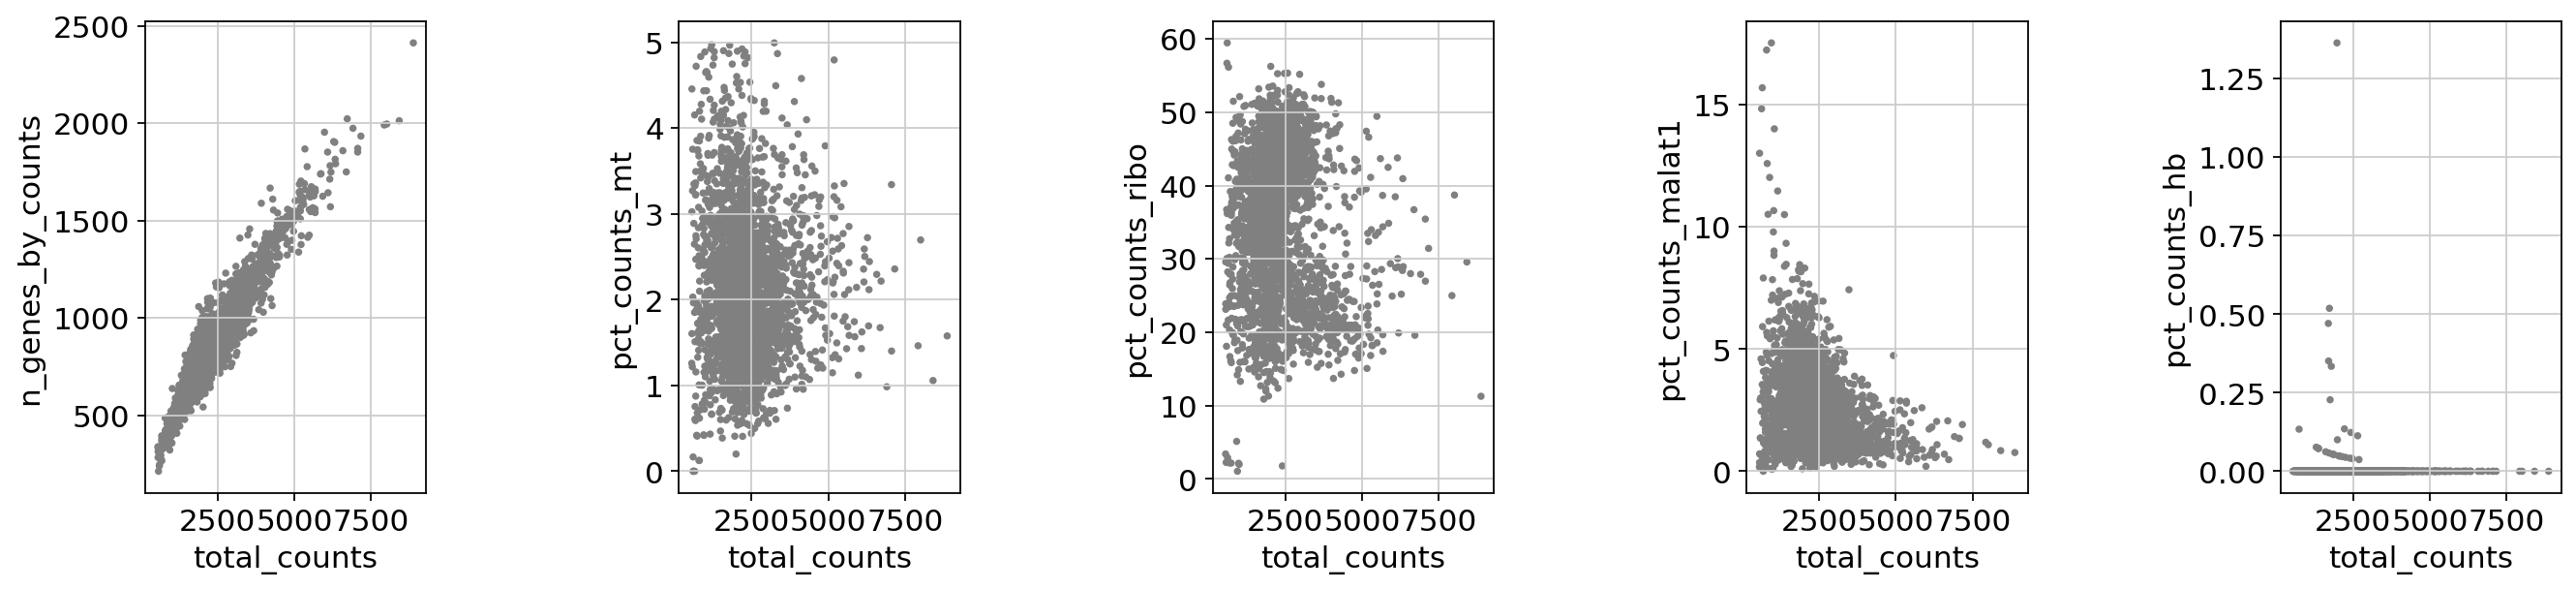

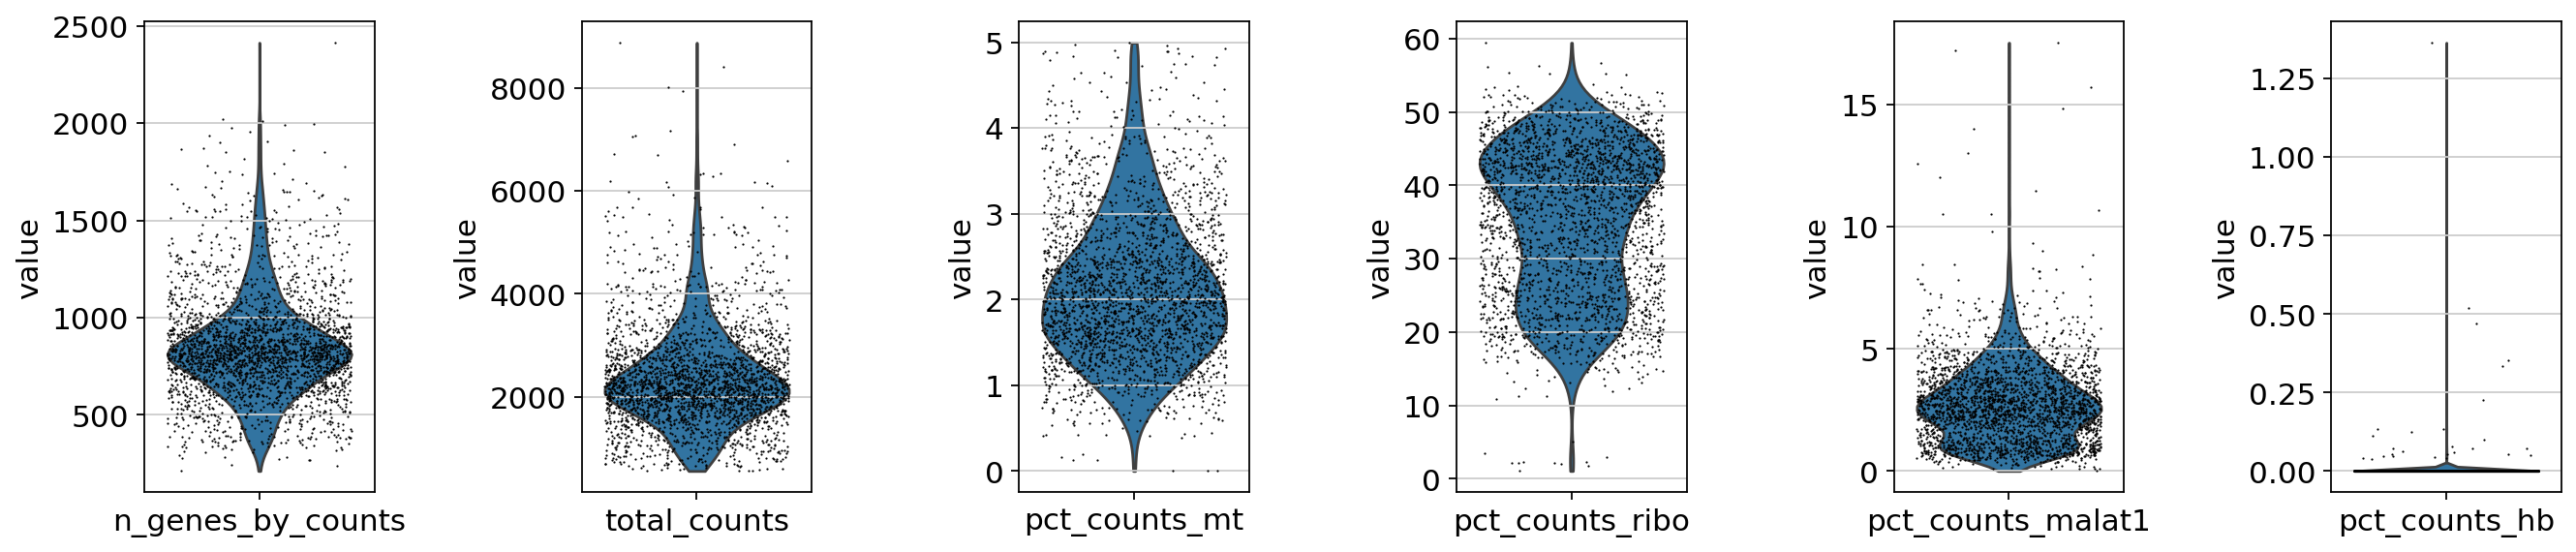

In [38]:
### now repeat this step after filtering

### annotate_QC_genes and calculate_qc_metrics functions

##  annotate_n_view_adata_raw_counts(adata)

# def annotate_QC_genes(adata):
adata.var['mt'] = adata.var_names.str.startswith("MT-")  # mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # ribosomal genes genes as 'ribo'
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)(S)]")) & ~adata.var_names.str.contains(("HBEGF")) 
# "^HB[^(P)" changed to "^HB[^(P)(S)" and  & ~adata_test.var_names.str.contains(("HBEGF")) added to remove HBS1L and HBEGF which are NOT memoglobin genes
adata.var['malat1'] = adata.var_names.str.contains(("MALAT1"))  # MALAT1 genes as 'malat1'

# def calculate_qc_metrics(adata):
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) # mitocohndrial  genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True) # ribosomal genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['hb'], percent_top=None, log1p=False, inplace=True) # hemoglobin genes.
sc.pp.calculate_qc_metrics(adata, qc_vars=['malat1'], percent_top=None, log1p=False, inplace=True) # MALAT1 gene.

# def plot_QC_metrics_scatter(adata):
figQC, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1 ,5,figsize=(20,4), gridspec_kw={'wspace':0.9})
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax=ax1, show=False) # plot number of dected genes vs total counts 
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',ax=ax2, show=False) #percent mt counts vs total counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo',ax=ax3, show=False) #percent ribo counts vs total counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_malat1',ax=ax4, show=False) #percent HB counts vs total count
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb',ax=ax5, show=False) #percent HB counts vs total counts 

#def plot_QC_metrics_violin(adata):
fig1, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1 ,6,figsize=(20,4), gridspec_kw={'wspace':0.9})
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4,ax=ax1, show=False)
sc.pl.violin(adata, ['total_counts'], jitter=0.4 ,ax=ax2, show=False)
sc.pl.violin(adata, [ 'pct_counts_mt'], jitter=0.4,ax=ax3, show=False) # mitocohndrial  genes
sc.pl.violin(adata, [ 'pct_counts_ribo'], jitter=0.4,ax=ax4, show=False) # ribosomal genes
sc.pl.violin(adata, [ 'pct_counts_malat1'], jitter=0.4,ax=ax5, show=False) # hemoglobin genes.
sc.pl.violin(adata, [ 'pct_counts_hb'], jitter=0.4,ax=ax6, show=False) # hemoglobin genes.

In [39]:

filter_HVG

True

####################################################  raw coutn perserved adata.layers["counts"] 
####################################################  library-size correct  the data
####################################################  Logarithmize  the data
############################# to adata.raw save filtered, normalized and logarithmized gene expression and plot
############################# the number of highly varriable gens are =  1838


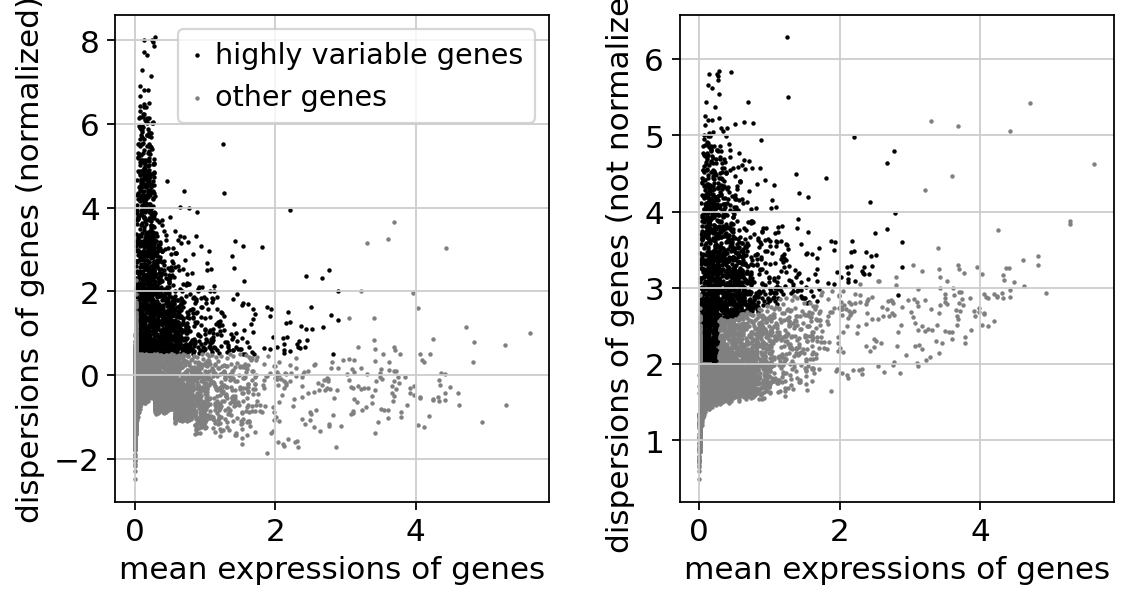

we are regressing out  total_counts True
we are regressing out  pct_counts_mt True
we are regressing out  pct_counts_ribo False
we are regressing out  pct_counts_malat1 False
we are regressing out  pct_counts_hb False


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


####################################################  Scale the data (each gene to unit variance)


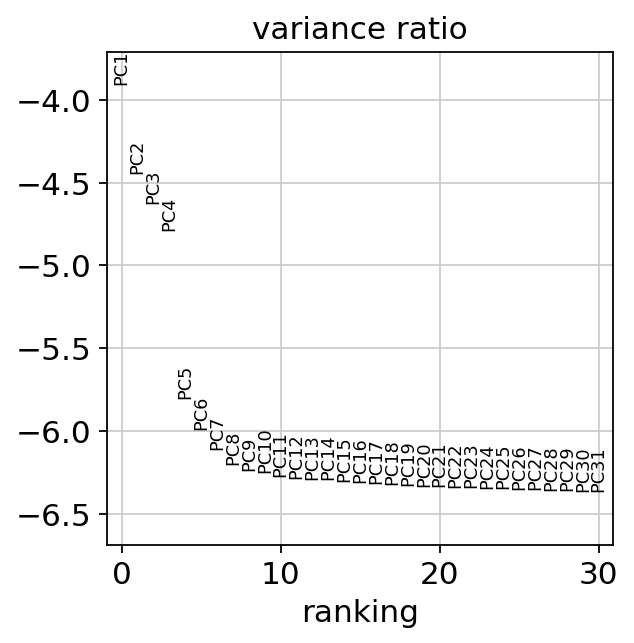

In [40]:


#########################################
## def norm_log()
print(f'####################################################  raw coutn perserved adata.layers["counts"] ')
adata.layers["counts"] = adata.X.copy()  # preserve counts
print(f'####################################################  library-size correct  the data')
################################## library-size correct  the data:
sc.pp.normalize_total(adata, target_sum=normalize_total_target_sum)    
if logarithmize==True:
    print(f'####################################################  Logarithmize  the data')
    print(f'############################# to adata.raw save filtered, normalized and logarithmized gene expression and plot')
    sc.pp.log1p(adata)
else:
     print(f'############################# to adata.raw save filtered and normalized gene expression and plot')
adata.raw = adata

### def HVG_selection_log_norm_sc()

sc.pp.highly_variable_genes(adata, min_mean=HVG_min_mean, max_mean=HVG_max_mean, min_disp=HVG_min_disp)
print(f'############################# the number of highly varriable gens are = ',sum(adata.var.highly_variable))
sc.pl.highly_variable_genes(adata) #### plot HVGs

######################################### filter_HVG
if filter_HVG==True:
    adata = adata[:, adata.var.highly_variable]
else:
    print(f' filter_HVG == False ... all genes will be kept ')
    
    
## regress_out_anotated_QC_genes()

################################# and Regression 
print(f'we are regressing out  total_counts {regress_mt}')
print(f'we are regressing out  pct_counts_mt {regress_mt}')
print(f'we are regressing out  pct_counts_ribo {regress_ribo}')
print(f'we are regressing out  pct_counts_malat1 {regress_malat1}')
print(f'we are regressing out  pct_counts_hb {regress_hb}')

################ Do the regression 
if regress_mt ==True:
    # by total_counts
    sc.pp.regress_out(adata, ['total_counts' ],n_jobs=n_jobs)
if regress_mt ==True:
    # by percent_mt
    sc.pp.regress_out(adata, ['pct_counts_mt' ],n_jobs=n_jobs)
if regress_ribo ==True:
    # by percent_ribo
    sc.pp.regress_out(adata, ['pct_counts_ribo' ],n_jobs=n_jobs)
if regress_malat1 ==True:
    # by percent_hb
    sc.pp.regress_out(adata, ['pct_counts_malat1'],n_jobs=n_jobs)
if regress_hb ==True:
    # by percent_hb
    sc.pp.regress_out(adata, ['pct_counts_hb' ],n_jobs=n_jobs)
    
    
if scale==True:
    print(f'####################################################  Scale the data (each gene to unit variance)')
    sc.pp.scale(adata, max_value=10)  # Scale and Clip values exceeding standard deviation 10.

######################################### PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [41]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'parameters', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

sc.pp.neighbors n_pcs= 40
sc.pp.neighbors n_neighbors= 10
sc.tl.leiden resolution= 0.9


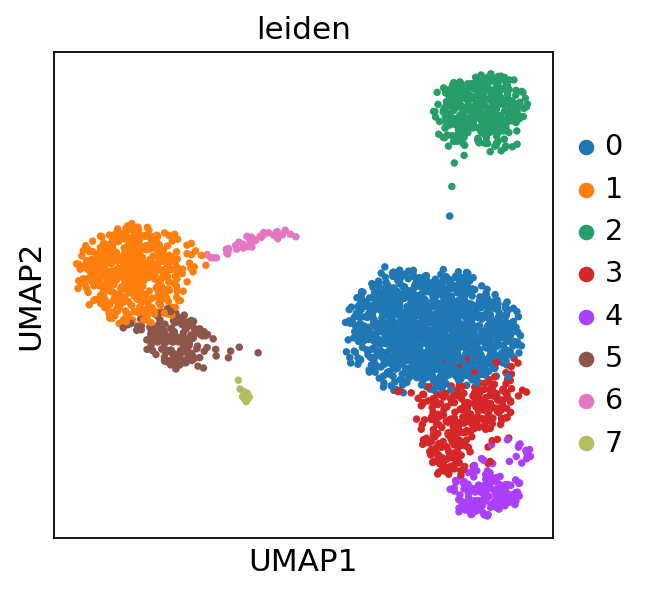

In [42]:


###clustering parameters for clusters

print(f"sc.pp.neighbors n_pcs=",adata.uns["parameters"]['number_of_PC'])
print(f"sc.pp.neighbors n_neighbors=",adata.uns["parameters"]['number_of_neighbors'])
print(f"sc.tl.leiden resolution=",adata.uns["parameters"]['leiden_res'])

sc.pp.neighbors(adata, n_neighbors=number_of_neighbors, n_pcs=number_of_PC)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=leiden_res)
sc.pl.umap(adata, color=['leiden' ] )

In [43]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1', 'leiden'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'parameters', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [44]:
new_obs_key='leiden_renamed'

cluster_numbers_len=len(set(adata.obs['leiden'].tolist()))
if cluster_numbers_len==len(new_cluster_names):
    adata.obs[new_obs_key]=adata.obs['leiden']
    adata.rename_categories(new_obs_key, new_cluster_names)
    ##################### cluster remnameing #####END

In [45]:
## add a custom color map for the umaps to show zero expression as grey
# Custom colormap where zero values are represented by grey
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['gray'] + list(plt.cm.viridis(np.linspace(0, 1, 256))))

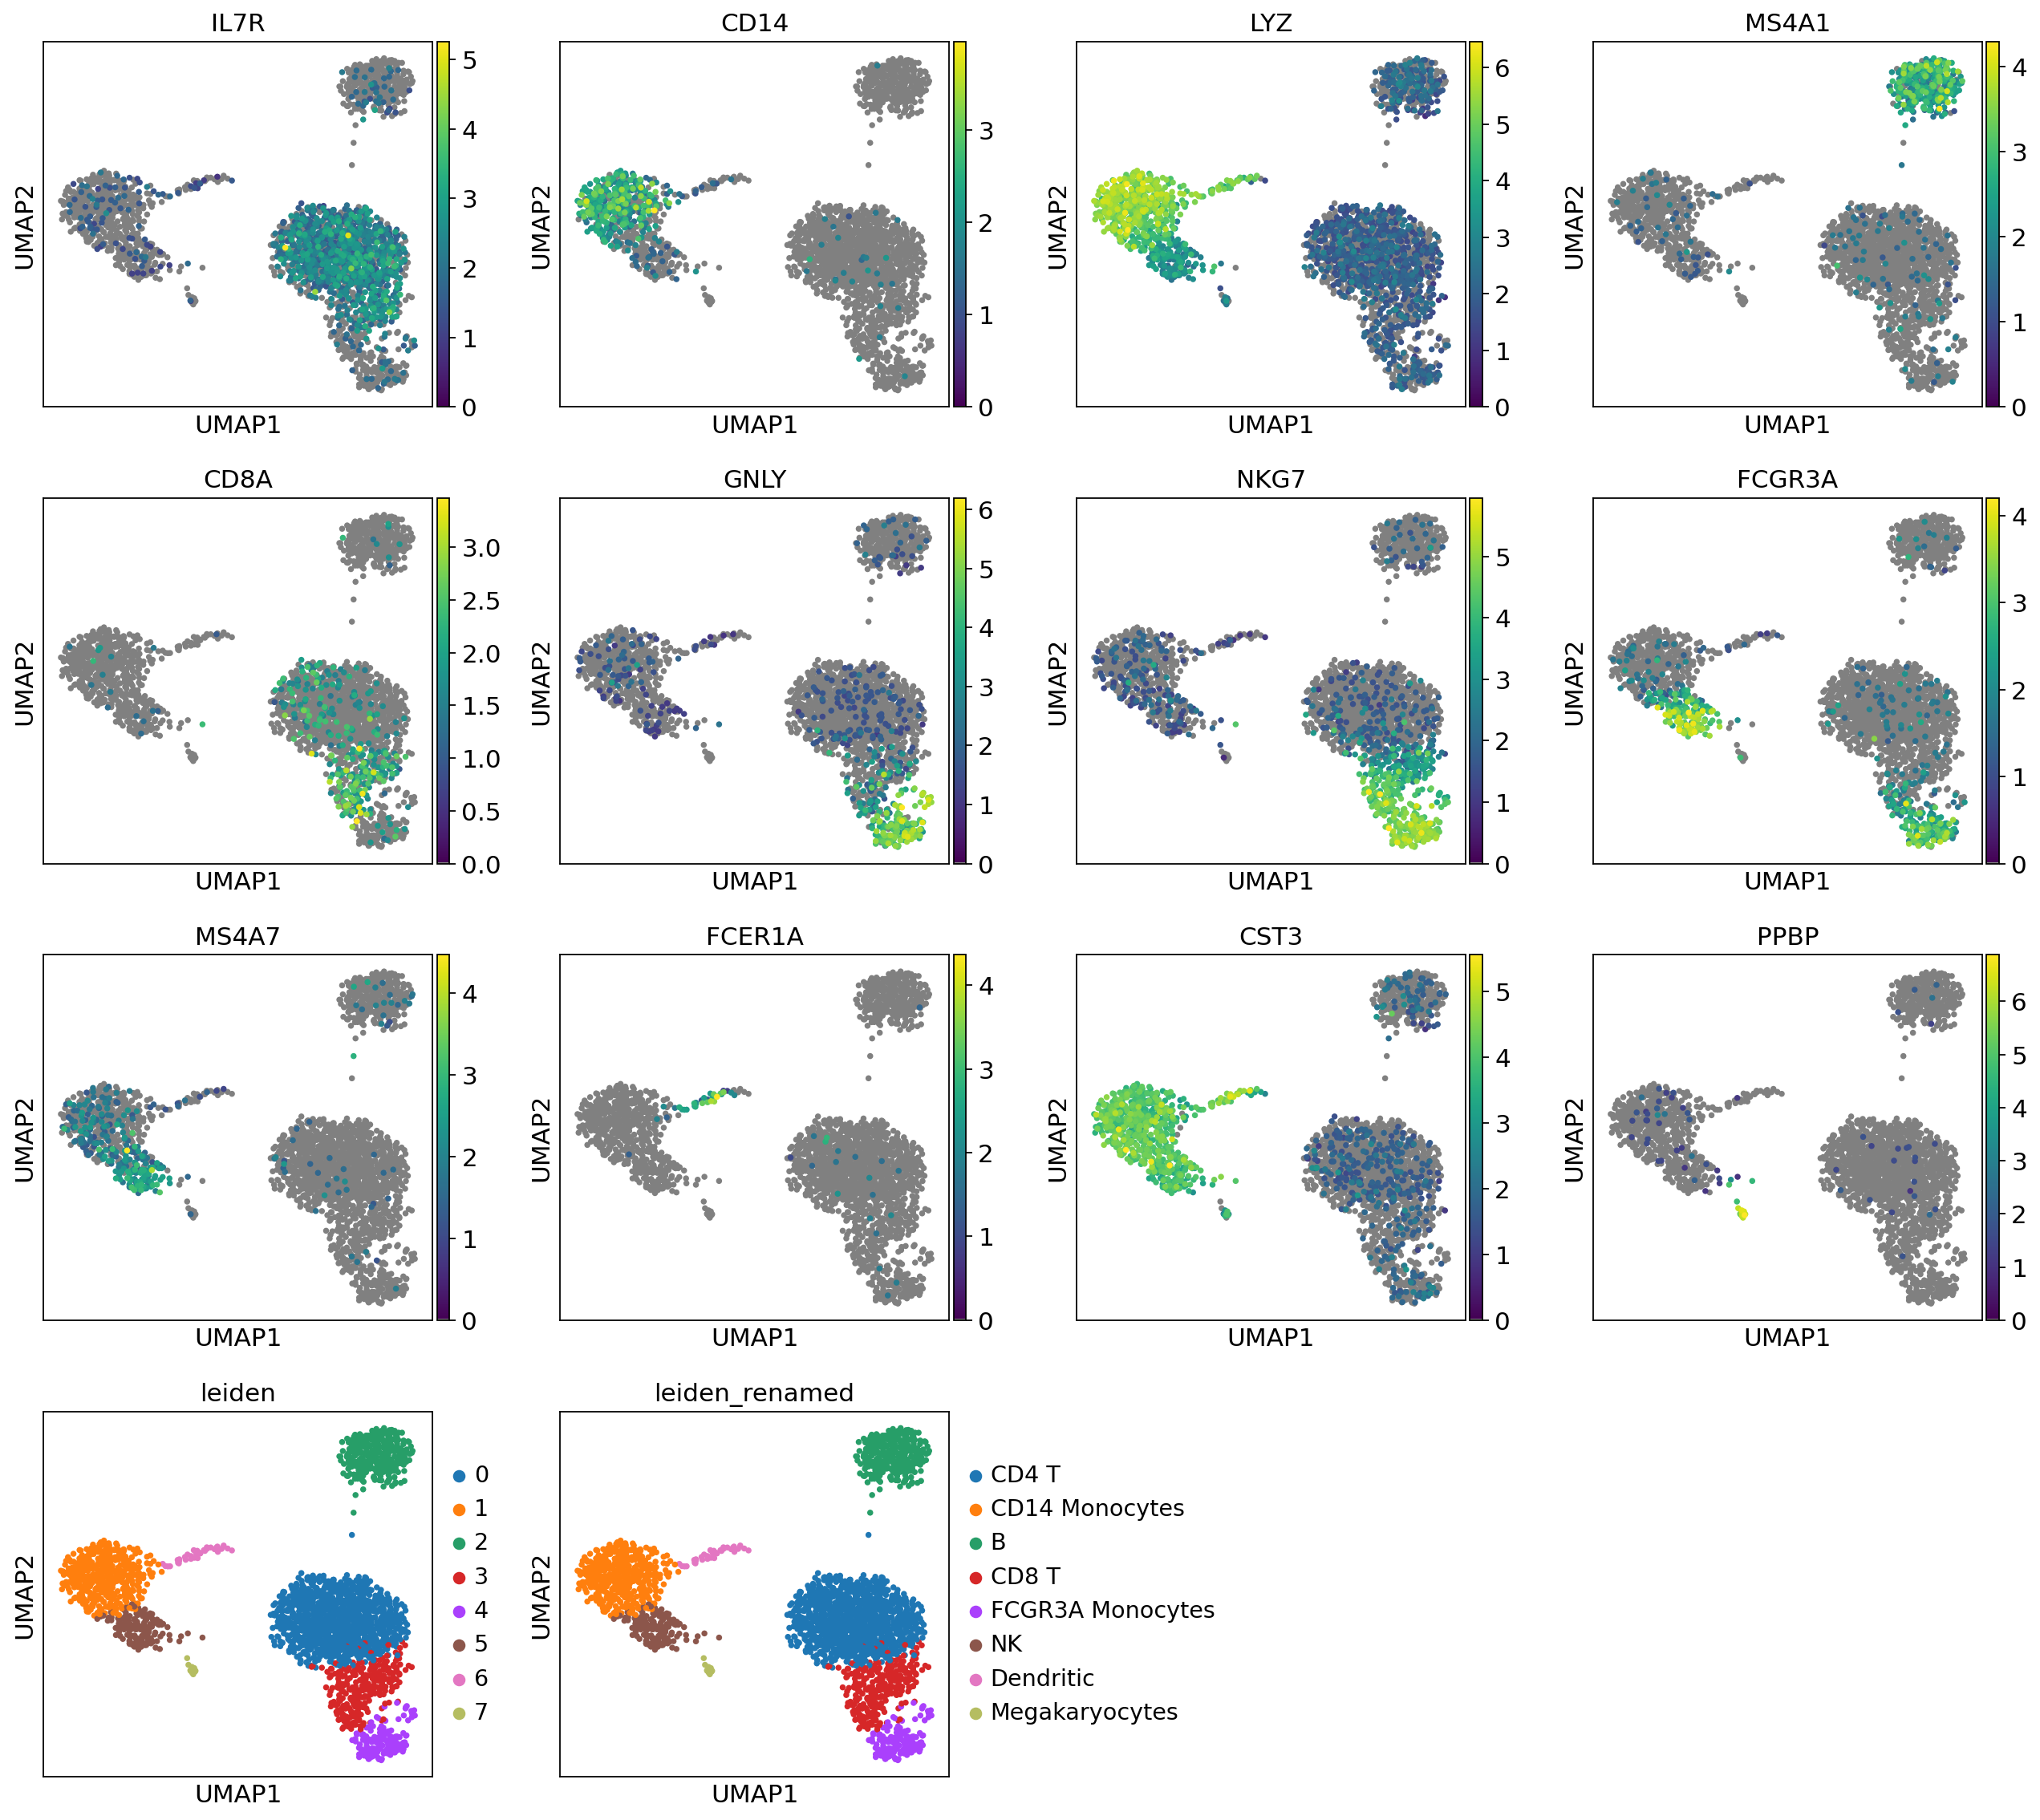

In [46]:
if cluster_numbers_len==len(new_cluster_names):
    umap_marker_gene_list=adata.uns["parameters"]["umap_marker_gene_list"]
    sc.pl.umap(adata, color=umap_marker_gene_list+['leiden','leiden_renamed'], cmap=cmap )

In [47]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1', 'leiden', 'leiden_renamed'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'parameters', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'leiden_renamed_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### END  do processing using scanpy fucnitons ( unwraped )